In [35]:
import numpy as np
import pandas as pd
import os
import shutil
from flashgeotext.geotext import GeoText
import re
import spacy

In [20]:
import spacy

nlp = spacy.load("en_core_web_md")  # make sure to use larger package!
doc1 = nlp("I like salty fries and hamburgers.")
doc2 = nlp("Fast food tastes very good.")

# Similarity of two documents
print(doc1, "<->", doc2, doc1.similarity(doc2))
# Similarity of tokens and spans
french_fries = doc1[2:4]
burgers = doc1[5]
print(french_fries, "<->", burgers, french_fries.similarity(burgers))

I like salty fries and hamburgers. <-> Fast food tastes very good. 0.691649353055761
salty fries <-> hamburgers 0.6938489675521851


In [21]:
[print(i.lemma_) for i in doc1.noun_chunks]

I
salty fry
hamburger


[None, None, None]

In [22]:
doc_test = nlp("On the inevitability of neural networks and other tasty topics of the 21st century")

In [23]:
[i.lemma_ for i in doc_test.noun_chunks]

['the inevitability',
 'neural network',
 'other tasty topic',
 'the 21st century']

In [24]:
doc1.vector.shape

(300,)

In [25]:
#spacy pipe example
"""tokens = []
lemma = []
pos = []

for doc in nlp.pipe(df['species'].astype('unicode').values, batch_size=50,
                        n_threads=3):
    if doc.is_parsed:
        tokens.append([n.text for n in doc])
        lemma.append([n.lemma_ for n in doc])
        pos.append([n.pos_ for n in doc])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)

df['species_tokens'] = tokens
df['species_lemma'] = lemma
df['species_pos'] = pos"""

"tokens = []\nlemma = []\npos = []\n\nfor doc in nlp.pipe(df['species'].astype('unicode').values, batch_size=50,\n                        n_threads=3):\n    if doc.is_parsed:\n        tokens.append([n.text for n in doc])\n        lemma.append([n.lemma_ for n in doc])\n        pos.append([n.pos_ for n in doc])\n    else:\n        # We want to make sure that the lists of parsed results have the\n        # same number of entries of the original Dataframe, so add some blanks in case the parse fails\n        tokens.append(None)\n        lemma.append(None)\n        pos.append(None)\n\ndf['species_tokens'] = tokens\ndf['species_lemma'] = lemma\ndf['species_pos'] = pos"

In [26]:
workdir_path=r"wos_extract"
outfile='wos_extract_complete.csv'
# with_header=True
# for root, dirs, files in os.walk(workdir_path):
#     for filename in files:
#         if filename.startswith("wosexport"):
#             path=os.path.join(root, filename)
#             print(path)
#             chunk = pd.read_excel(path)
#             chunk.to_csv(outfile, mode="a", index=False, header=with_header, sep="\t")
#             with_header = False

In [27]:
record_col="UT (Unique WOS ID)"

In [28]:
wos = pd.read_csv(outfile, sep="\t",low_memory=False)
metrix = pd.read_excel("sm_journal_classification.xlsx", sheet_name="Journal_Classification")


metrix = metrix.set_index([c for c in metrix.columns if "issn" not in c]).stack().reset_index()
metrix = metrix.rename(columns={'level_6':"issn_type", 0:"issn"})
metrix["issn"]=metrix["issn"].str.replace("-","").str.lower().str.strip()

wos["issn"] = wos["ISSN"].str.replace("-","").str.lower().str.strip()
wos["eissn"] = wos["eISSN"].str.replace("-","").str.lower().str.strip()
wos = wos.set_index([c for c in wos.columns if "issn" not in c]).stack().reset_index()
wos = wos.rename(columns={'level_72':"issn_var", 0:"issn"})

wos_merge = wos.merge(metrix, on="issn", how="left")
wos = wos_merge.sort_values(by="issn_var",ascending=False).drop_duplicates(subset=record_col)

In [29]:
pd.Series(wos.columns)

0       Publication Type
1                Authors
2           Book Authors
3           Book Editors
4     Book Group Authors
             ...        
76      SubField_English
77              2.00 SEQ
78          Source_title
79                 srcid
80             issn_type
Length: 81, dtype: object

In [30]:
wos["Researcher Ids"]

0        Salucci, Marco/S-8654-2016; Arrebola, Manuel/L...
9714                               Huang, Yu/AAY-5464-2020
9697     Kakavand, Mohammad Reza Azadi/X-9556-2019; Fen...
9699     Dong, Sheng/AAE-3619-2021; Soares, Carlos Gued...
9701     Han, Guoqi/T-7365-2019; Nan, Yang/HKD-9687-202...
                               ...                        
3066                         ; Liotta, Antonio/G-9532-2014
5097        , 卢帅/AAK-2185-2020; Popp, József/AFN-1250-2022
11369                                                  NaN
11368                            Rossiter, D G/D-3842-2009
11362                           Jin, Shuanggen/B-8094-2008
Name: Researcher Ids, Length: 9889, dtype: object

In [31]:
wos[(~wos["DOI"].isna())&(wos["DOI"].duplicated(False))]

Publication Type                                            Authors   
16979                J  Zhang, MS; Huang, J; Cao, Y; Xiong, CH; Mohamm...  \
1880                 J  Zhang, MS; Huang, J; Cao, Y; Xiong, CH; Mohamm...   

      Book Authors Book Editors Book Group Authors   
16979          NaN          NaN                NaN  \
1880           NaN          NaN                NaN   

                                       Author Full Names   
16979  Zhang, Mengshi; Huang, Jian; Cao, Yu; Xiong, C...  \
1880   Zhang, Mengshi; Huang, Jian; Cao, Yu; Xiong, C...   

      Book Author Full Names Group Authors   
16979                    NaN           NaN  \
1880                     NaN           NaN   

                                           Article Title   
16979  Echo State Network-Enhanced Super-Twisting Con...  \
1880   Echo State Network-Enhanced Super-Twisting Con...   

                                 Source Title  ... Web of Science Record   
16979  IEEE-ASME TRANSACTIONS ON MECHATRONICS  ...                     0  \
1880   IEEE-ASME TRANSACTIONS ON MECHATRONICS  ...                     0   

       issn_var      issn    Domain_English Field_English   
16979      issn  10834435  Applied Sciences   Engineering  \
1880       issn  10834435  Applied Sciences   Engineering   

                          SubField_English 2.00 SEQ   
16979  Industrial Engineering & Automation       27  \
1880   Industrial Engineering & Automation       27   

                                 Source_title    srcid issn_type  
16979  IEEE/ASME Transactions on Mechatronics  19113.0     issn1  
1880   IEEE/ASME Transactions on Mechatronics  19113.0     issn1  

[2 rows x 81 columns]

In [32]:
wos[[record_col,"Keywords Plus","Author Keywords","Article Title","Abstract"]]


UT (Unique WOS ID)                                      Keywords Plus   
0      WOS:000852293800024  CONVOLUTIONAL NEURAL-NETWORK; DEEP LEARNING FR...  \
9714   WOS:000540750000002  STATE-SPACE RECONSTRUCTION; SURFACE AIR-TEMPER...   
9697   WOS:000600708400002  COMPRESSIVE STRENGTH; MODELS; ADABOOST.RT; DUC...   
9699   WOS:000511965100005              STRUCTURAL RELIABILITY; FAILURE MODES   
9701   WOS:000663142500003  REFLECTED GPS SIGNALS; SOIL-MOISTURE; OCEAN; S...   
...                    ...                                                ...   
3066   WOS:000528727500074           LOCAL SEARCH; ALGORITHM; VARIANCE; MODEL   
5097   WOS:000596139400001  INDUSTRY 4.0; MANAGEMENT; RISK; ANALYTICS; CHA...   
11369  WOS:000436774300069                                                NaN   
11368  WOS:000846290700001  PARTIAL LEAST-SQUARES; INFRARED-SPECTROSCOPY; ...   
11362  WOS:000480527800025  MICROWAVE DIELECTRIC BEHAVIOR; GPS SIGNALS; RE...   

                                         Author Keywords   
0      Imaging; Three-dimensional displays; Electroma...  \
9714                                                 NaN   
9697   Plastic hinge length; RC columns; Machine lear...   
9699   system reliability; jacket platform; beta-unzi...   
9701   Cyclone GNSS (CYGNSS); Sea surface wind speed;...   
...                                                  ...   
3066   sea surface temperature; sea surface temperatu...   
5097   Big data finance; Big data in financial servic...   
11369  planetary gear; fault diagnosis; VMD; center f...   
11368  soil fertility class; reflectance spectroscopy...   
11362  global navigation satellite system (GNSS)-refl...   

                                           Article Title   
0      Artificial Intelligence: New Frontiers in Real...  \
9714   Detecting causality from time series in a mach...   
9697   Data-Driven Approach to Predict the Plastic Hi...   
9699   System Reliability Analysis of an Offshore Jac...   
9701   Analysis of coastal wind speed retrieval from ...   
...                                                  ...   
3066   Improved Particle Swarm Optimization for Sea S...   
5097   Current landscape and influence of big data on...   
11369  Planetary Gear Fault Diagnosis via Feature Ima...   
11368  How Well Can Reflectance Spectroscopy Allocate...   
11362  GNSS-R Soil Moisture Retrieval Based on a XGbo...   

                                                Abstract  
0      In recent years, artificial intelligence (AI) ...  
9714   Detecting causality from observational data is...  
9697   Inelastic response of reinforced concrete colu...  
9699   This study investigates strategies for solving...  
9701   This paper demonstrates the capability and per...  
...                                                  ...  
3066   The Sea Surface Temperature (SST) is one of th...  
5097   Big data is one of the most recent business an...  
11369  Poor working environment leads to frequent fai...  
11368  Fertilization decisions depend on the measurem...  
11362  Global navigation satellite system (GNSS)-refl...  

[9889 rows x 5 columns]

In [68]:
kw_df = pd.DataFrame()
for c in ["Keywords Plus","Author Keywords"]:
    kwp = wos.groupby(record_col)[c].apply(lambda x: x.str.split(';')).explode().str.strip().str.upper()
    kwp.name = 'keyword_all'
    kw_df = pd.concat([kwp.reset_index(),kw_df],ignore_index=True)
kw_df = kw_df[~kw_df["keyword_all"].isna()].copy().drop(columns="level_1").drop_duplicates()
kw_df["keyword_all"] = kw_df["keyword_all"].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x))
kw_df.head(100)

UT (Unique WOS ID)                       keyword_all
1    WOS:000297893800037  ADAPTIVE DYNAMIC SURFACE CONTROL
2    WOS:000297893800037                NEURAL COMPENSATOR
3    WOS:000297893800037                    BUCK CONVERTER
4    WOS:000297893800037            FINITE-TIME IDENTIFIER
5    WOS:000301090100061              TEMPORAL CONJUNCTION
..                   ...                               ...
99   WOS:000309409400280             SCIENTIFIC DATA CLOUD
100  WOS:000309409400280                VIRTUAL DATASPACES
101  WOS:000309409400280              SEMANTIC INTEGRATION
102  WOS:000309409400280                          ONTOLOGY
103  WOS:000309409400280                     PAY-AS-YOU-GO

[100 rows x 2 columns]

In [69]:
wos_kwd_concat = kw_df.groupby(record_col, as_index=False).agg({'keyword_all': '; '.join})
wos_kwd_concat.head()

UT (Unique WOS ID)                                        keyword_all
0  WOS:000297893800037  ADAPTIVE DYNAMIC SURFACE CONTROL; NEURAL COMPE...
1  WOS:000301090100061  TEMPORAL CONJUNCTION; CAUDATE NUCLEUS; PREFRON...
2  WOS:000301155300013  AUTOMATIC INCIDENT DETECTION; DATA CLEANSING; ...
3  WOS:000301973200015  TRACHEO-BRONCHIAL; LUNG; INNERVATION; ESOPHAGE...
4  WOS:000302289400006  LINGUISTIC ANNOTATION; ANNOTATION TOOLS; INTER...

In [34]:
from keybert import KeyBERT

# Uses stopwords for english from NLTK, and all puntuation characters by
# default
kw_model = KeyBERT(model='all-mpnet-base-v2')

# Extraction given the text.
# r.extract_keywords_from_text(<text to process>)

# keywords = kw_model.extract_keywords(full_text,
#
#                                      keyphrase_ngram_range=(1, 3),
#
#                                      stop_words='english',
#
#                                      highlight=False,
#
#                                      top_n=10)
#
# keywords_list= list(dict(keywords).keys())

In [78]:
def kwd_extract(text):
    keywords = kw_model.extract_keywords(text,

                                     keyphrase_ngram_range=(1, 2),

                                     stop_words='english',

                                     highlight=False,

                                     top_n=3)
    return "; ".join([i[0].upper() for i in keywords])

kwd_extract(text="Artificial Intelligence: New Frontiers in Real-Time Inverse Scattering and Electromagnetic Imaging - In recent years, artificial intelligence (AI) techniques have been developed rapidly. With the ...")

'ELECTROMAGNETIC IMAGING; INVERSE SCATTERING; SCATTERING ELECTROMAGNETIC'

'ELECTROMAGNETIC IMAGING; INVERSE SCATTERING; SCATTERING ELECTROMAGNETIC; SCATTERING; AI; ELECTROMAGNETIC; IMAGING; ARTIFICIAL INTELLIGENCE'

In [86]:
wos_nlp = wos[[record_col,"Article Title","Abstract"]]
wos_nlp = wos_nlp.merge(wos_kwd_concat, on = record_col)
wos_nlp["Document"] = wos_nlp["Article Title"].str.cat(wos_nlp[["Abstract","keyword_all"]].fillna(""), sep=' - ')
# wos_kwd_test["BERT_KWDS"] = wos_kwd_test["Document"].map(kwd_extract)

vectors = list()
vector_norms = list()

for doc in nlp.pipe(wos_nlp['Document'].astype('unicode').values, batch_size=100,
                        n_process=4):
    vectors.append(doc.vector)
    vector_norms.append(doc.vector_norm)

wos_nlp['vector'] = vectors
wos_nlp['vector_norm'] = vector_norms

<Axes: ylabel='Frequency'>

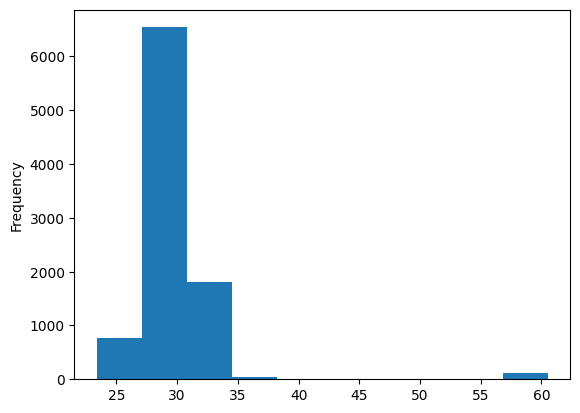

In [84]:
wos_nlp['vector_norm'].plot(kind="hist")

In [85]:
wos_nlp[wos_nlp['vector_norm']>50]

UT (Unique WOS ID)                                      Article Title   
79    WOS:000852230800001  Deep Learning-Based Object Tracking in Satelli...  \
87    WOS:000732189300001          Hyperspectral Anomaly Detection: A Survey   
248   WOS:000446451700003  New Frontiers in Spectral-Spatial Hyperspectra...   
276   WOS:000728108300001  IEEE ACCESS SPECIAL SECTION EDITORIAL: BIG DAT...   
365   WOS:000376531500004  Future Perspectives and Challenges of Fungal S...   
...                   ...                                                ...   
8855  WOS:000541900700064  Statistical Machine Learning for Human Behavio...   
8869  WOS:000756384800001  Editorial: Artificial Intelligence in Positron...   
8891  WOS:000638348600001  Advancing Grid-Connected Renewable Generation ...   
8918  WOS:000859103100001  Editorial: Systems biology approach for the me...   
8925  WOS:000885247700001  Editorial: Investigation of brain functional c...   

     Abstract                                        keyword_all Document   
79        NaN  FEATURE EXTRACTION; TRANSFORMERS; OBJECT TRACK...      NaN  \
87        NaN  ANOMALY DETECTION; HYPERSPECTRAL IMAGING; PRIN...      NaN   
248       NaN  LOOPY BELIEF PROPAGATION; EXTINCTION PROFILES;...      NaN   
276       NaN  FEATURE-SELECTION; NEURAL-NETWORKS; STOCK-MARK...      NaN   
365       NaN  INTERNAL TRANSCRIBED SPACER; ASPERGILLUS-NIGER...      NaN   
...       ...                                                ...      ...   
8855      NaN  ACTION RECOGNITION; EMOTION RECOGNITION; PRIVA...      NaN   
8869      NaN  ARTIFICIAL INTELLIGENCE; MOLECULAR IMAGING; PO...      NaN   
8891      NaN  RENEWABLE ENERGY SOURCES ; POWER QUALITY; VIRT...      NaN   
8918      NaN  CHRONIC LIVER DISEASE; OMICS; SYSTEMATIC BIOLO...      NaN   
8925      NaN  BRAIN; FUNCTIONAL CONNECTIVITY; EEG; ELECTROEN...      NaN   

                                                 vector  vector_norm  
79    [0.53393, -0.6493, -3.1156, -0.04664, -2.6227,...    60.533962  
87    [0.53393, -0.6493, -3.1156, -0.04664, -2.6227,...    60.533962  
248   [0.53393, -0.6493, -3.1156, -0.04664, -2.6227,...    60.533962  
276   [0.53393, -0.6493, -3.1156, -0.04664, -2.6227,...    60.533962  
365   [0.53393, -0.6493, -3.1156, -0.04664, -2.6227,...    60.533962  
...                                                 ...          ...  
8855  [0.53393, -0.6493, -3.1156, -0.04664, -2.6227,...    60.533962  
8869  [0.53393, -0.6493, -3.1156, -0.04664, -2.6227,...    60.533962  
8891  [0.53393, -0.6493, -3.1156, -0.04664, -2.6227,...    60.533962  
8918  [0.53393, -0.6493, -3.1156, -0.04664, -2.6227,...    60.533962  
8925  [0.53393, -0.6493, -3.1156, -0.04664, -2.6227,...    60.533962  

[121 rows x 7 columns]

In [77]:
np.array(wos_nlp["vector"].to_list())

array([[-1.8670139 , -1.6925758 ,  0.48349068, ..., -2.2703056 ,
        -1.4200605 ,  0.46284062],
       [-1.7312453 , -0.4499114 , -0.54250187, ..., -2.2334094 ,
        -1.3671577 ,  0.7283594 ],
       [-2.3378334 , -0.424522  , -0.82274777, ..., -2.2994597 ,
        -1.5955478 ,  0.26363412],
       ...,
       [-2.3435452 , -0.34531432, -1.1484123 , ..., -2.3003943 ,
        -1.8553756 , -0.31917948],
       [-2.8046715 , -1.7071993 ,  0.55096555, ..., -2.709951  ,
        -0.621031  ,  0.46265596],
       [-2.2533355 , -0.8899313 ,  0.08667578, ..., -2.5975435 ,
        -1.0989579 ,  1.2003326 ]], dtype=float32)

In [8]:
geotext = GeoText()

def extract_location(input_text, key='countries'):
    anomalies = {"Malta":"Malta",
                 "Mongolia":"Mongolia",
                 "Quatar":"Qatar",
                 "Qatar":"Qatar",
                 "Ethiop":"Ethiopia",
                 "Nigeria":"Nigeria",
                 "BELAR":"Belarus",
                 "Venezuela":"Venezuela",
                 "Cyprus":"Cyprus",
                 "Ecuador":"Ecuador",
                 "U Arab":"United Arab Emirates",
                 "Syria":"Syria",
                 "Uganda":"Uganda",
                 "Yemen":"Yemen",
                 "Mali":"Mali",
                 "Senegal":"Senegal",
                 "Vatican":"Vatican",
                 "Uruguay":"Uruguay",
                 "Panama":"Panama",
                 "Fiji":"Fiji",
                 "Faroe":"Faroe Islands",
                 "Macedonia":"Macedonia",
                 'Mozambique':'Mozambique',
                 "Kuwait":"Kuwait",
                 "Libya":"Libya",
                 "Turkiy":"Turkey",
                 "Liberia":"Liberia",
                 "Namibia":"Namibia",
                 "Ivoire":"Ivory Coast",
                 "Guatemala":"Gutemala",
                 "Paraguay":"Paraguay",
                 "Honduras":"Honduras",
                 "Nicaragua":"Nicaragua",
                 "Trinidad":"Trinidad & Tobago",
                 "Liechtenstein":"Liechtenstein",
                 "Greenland":"Denmark"}

    extracted = geotext.extract(input_text=input_text)
    found = extracted[key].keys()
    if len(sorted(found))>0:
        return sorted(found)[0]
    elif key=='countries':
        for i  in ['Scotland','Wales','England']:
            if i in input_text:
                return 'United Kingdom'
        for j in anomalies.keys():
            if j in input_text:
                return anomalies.get(j)
    else:
        return None

with open('../eu_members.txt',"r") as f:
    eu_countries=f.readline().split(",")
    eu_countries=[i.strip() for i in eu_countries]

def country_type(country):
    if country in eu_countries:
        return "EU"
    elif country=="China":
        return "China"
    else:
        return "Other"


In [9]:
locations = wos.groupby(record_col)["Addresses"].apply(lambda x: x.str.split('[')).explode().reset_index().drop(columns="level_1")
locations = locations[locations["Addresses"]!=""].copy()
locations["Address"] = locations["Addresses"].apply(lambda x:x.split("]")[-1])
locations["Authors_of_address"] = locations["Addresses"].apply(lambda x:x.split("]")[0])
locations["Country"]=locations['Address'].apply(lambda x: extract_location(input_text=x, key='countries'))
locations["City"]=locations['Address'].apply(lambda x: extract_location(input_text=x, key='cities'))
locations["Country_Type"] = locations["Country"].apply(lambda x: country_type(x))

In [10]:
univ_locations = locations[[record_col,"Address","Country","City","Country_Type"]].copy()
univ_locations["Institution"] = univ_locations["Address"].apply(lambda x: x.split(",")[0])
univ_locations.head()

UT (Unique WOS ID)                                            Address   
1  WOS:000209536100003   BGI HK Ltd, GigaSci, Tai Po, Hong Kong, Peopl...  \
2  WOS:000209536100003         Nat Hist Museum, London SW7 5BD, England;    
3  WOS:000209536100003              Pensoft Publishers, Sofia, Bulgaria;    
4  WOS:000209536100003    Nat Hist Museum, Natl Museum, Sofia, Bulgaria;    
5  WOS:000209536100003   Bulgarian Acad Sci, Inst Biodivers & Ecosyst ...   

          Country       City Country_Type          Institution  
1           China  Hong Kong        China           BGI HK Ltd  
2  United Kingdom     London        Other      Nat Hist Museum  
3        Bulgaria      Sofia           EU   Pensoft Publishers  
4        Bulgaria      Sofia           EU      Nat Hist Museum  
5        Bulgaria       Rees           EU   Bulgarian Acad Sci

In [11]:
locations["Country"].value_counts()

Country
China            21063
United States     5913
Germany           4179
Italy             3195
France            2767
                 ...  
Faroe Islands        1
Honduras             1
Vatican              1
Macedonia            1
Jamaica              1
Name: count, Length: 137, dtype: int64

In [12]:
locations["Country_Type"].value_counts()

Country_Type
EU       21228
China    21063
Other    20404
Name: count, dtype: int64

In [13]:
author_locations = locations.groupby([record_col,"Country","Country_Type"])["Authors_of_address"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_3")
author_locations["Author_name"] = author_locations["Authors_of_address"].str.strip()
author_locations = author_locations.drop(columns="Authors_of_address")
author_locations["author_str_id"] = author_locations["Author_name"].apply(lambda x:''.join(filter(str.isalnum, x.lower())))
author_locations

UT (Unique WOS ID)   Country Country_Type        Author_name   
0       WOS:000209536100003  Bulgaria           EU       Stoev, Pavel  \
1       WOS:000209536100003  Bulgaria           EU    Penev, Lyubomir   
2       WOS:000209536100003  Bulgaria           EU       Stoev, Pavel   
3       WOS:000209536100003  Bulgaria           EU    Penev, Lyubomir   
4       WOS:000209536100003     China        China  Edmunds, Scott C.   
...                     ...       ...          ...                ...   
173441  WOS:000947693400001     China        China        Peng, Sihua   
173442  WOS:000947693400001     China        China       Shen, Zhehan   
173443  WOS:000947693400001     China        China       Shen, Zhehan   
173444  WOS:000947693400001     China        China       Liu, Taigang   
173445  WOS:000947693400001     Spain           EU      Jiang, Linhua   

        author_str_id  
0          stoevpavel  
1       penevlyubomir  
2          stoevpavel  
3       penevlyubomir  
4       edmundsscottc  
...               ...  
173441      pengsihua  
173442     shenzhehan  
173443     shenzhehan  
173444     liutaigang  
173445    jianglinhua  

[173446 rows x 5 columns]

In [14]:
author_primary_region = author_locations.sort_values(by="Country_Type").drop_duplicates(subset=[record_col,"author_str_id"])
# author_primary_region

china=author_primary_region[author_primary_region["Country_Type"]=="China"][record_col].unique()
eu=author_primary_region[author_primary_region["Country_Type"]=="EU"][record_col].unique()

len(wos[((wos[record_col].isin(china))
         &
         (wos[record_col].isin(eu)))])

8925

In [15]:
len(wos)

9889

In [16]:
affiliations = wos.groupby(record_col)["Affiliations"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_1")
# affiliations[affiliations["Affiliations"].str.lower().str.contains("chinese academy", na=False, regex=True)]["Affiliations"].value_counts()
affiliations["Affiliations"] = affiliations["Affiliations"].str.strip().str.upper().fillna("UNKNOWN")
affiliations = affiliations.drop_duplicates()

In [17]:
aff_ = wos.groupby(record_col)["Affiliations"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_1")
loc_ = wos.groupby(record_col)["Addresses"].apply(lambda x: x.str.split('[')).explode().reset_index().drop(columns="level_1")
print(len(aff_),len(loc_))

76485 72581


In [18]:
unique_inst = sorted([i.split(" ") for i in list(affiliations["Affiliations"].unique())], key=len)
# unique_inst = [[''.join(filter(str.isalnum, i)) for i in i_list] for i_list in unique_inst]
unique_inst = [[i.strip(",").strip("(").strip(")") for i in i_list] for i_list in unique_inst]
unique_inst

[['IDAHO'],
 ['ICREA'],
 ['CEA'],
 ['AGROPARISTECH'],
 ['LENOVO'],
 ['RIKEN'],
 ['MICROSOFT'],
 ['GLAXOSMITHKLINE'],
 ['UNICANCER'],
 ['INRIA'],
 ['CIBERESP'],
 ['SINOPEC'],
 ['PHILIPS'],
 ['CIRAD'],
 ['VITO'],
 ['IMEC'],
 ['ILLUMINA'],
 ['EURECOM'],
 ['BAIDU'],
 ['CIBEREHD'],
 ['UNKNOWN'],
 ['BAYCREST'],
 ['NOVARTIS'],
 ['ITER'],
 ['PELIN'],
 ['INRAE'],
 ['ASTRAZENECA'],
 ['ERICSSON'],
 ['IDIBAPS'],
 ['CGIAR'],
 ['UNILEVER'],
 ['GENENTECH'],
 ['TENCENT'],
 ['NICTA'],
 ['QUALCOMM'],
 ['INESC-ID'],
 ['CIBERES'],
 ['ALCATEL-LUCENT'],
 ['TEAGASC'],
 ['ABB'],
 ['HEWLETT-PACKARD'],
 ['AT&T'],
 ['RIGSHOSPITALET'],
 ['FORTISS'],
 ['AMAZON.COM'],
 ['BASF'],
 ['BOSCH'],
 ['CIBERSAM'],
 ['EURATOM'],
 ['UNINETTUNO'],
 ['E-ON'],
 ['DELPHI'],
 ['BIOGEN'],
 ['SAMSUNG'],
 ['INTERDIGITAL'],
 ['SYNGENTA'],
 ['CIBERONC'],
 ['IRTA'],
 ['MICA'],
 ['MEDTRONIC'],
 ['IFREMER'],
 ['DELTARES'],
 ['PROFIL'],
 ['SANOFI-AVENTIS'],
 ['REGENERON'],
 ['YUTONG'],
 ['CIBERBBN'],
 ['KAKAO'],
 ['DNV'],
 ['SCHLUMBERGER']

In [19]:
def institution_chunk_norris(text):
    for i in unique_inst:
        text_split=text.split(" ")
        text_split=[i.strip(",").strip("(").strip(")") for i in text_split]
        overlap = all(token in text_split for token in i)
        if overlap:
            return (" ".join(i))
    return "ERROR"

In [20]:
affiliations["Affiliations_merged"] = affiliations["Affiliations"].apply(lambda x: institution_chunk_norris(x))

In [21]:
affiliations["Affiliations"].value_counts()

Affiliations
CHINESE ACADEMY OF SCIENCES                            1188
UDICE-FRENCH RESEARCH UNIVERSITIES                      647
CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE (CNRS)     640
HELMHOLTZ ASSOCIATION                                   427
UNIVERSITY OF CHINESE ACADEMY OF SCIENCES, CAS          411
                                                       ... 
IMT NORD EUROPE                                           1
SANGMYUNG UNIVERSITY                                      1
INDIANA UNIVERSITY PURDUE UNIVERSITY FORT WAYNE           1
JAHANGIRNAGAR UNIVERSITY                                  1
SAINT JAMES'S UNIVERSITY HOSPITAL                         1
Name: count, Length: 4884, dtype: int64

In [22]:
affiliations["Affiliations_merged"].value_counts()

Affiliations_merged
CHINESE ACADEMY OF SCIENCES                          1725
NANJING UNIVERSITY                                    737
SHANGHAI UNIVERSITY                                   667
UDICE-FRENCH RESEARCH UNIVERSITIES                    647
CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE CNRS     640
                                                     ... 
ULVAC INC.                                              1
NATIONAL METROLOGY INSTITUTE OF JAPAN                   1
SHEFFIELD HALLAM UNIVERSITY                             1
GLOBAL INSTITUTE FOR WATER SECURITY                     1
SAINT JAMES'S UNIVERSITY HOSPITAL                       1
Name: count, Length: 4241, dtype: int64

In [23]:
affiliations[affiliations["Affiliations_merged"]=="ERROR"]

Empty DataFrame
Columns: [UT (Unique WOS ID), Affiliations, Affiliations_merged]
Index: []

In [43]:
from nltk.metrics import edit_distance
from nltk.metrics import edit_distance_align
#results = df.apply(lambda x: edit_distance(x["column1"], x["column2"]), axis=1)

In [25]:
affiliations = affiliations.merge(univ_locations, on=record_col)

In [26]:
affiliations["Affiliations"] = affiliations["Affiliations"].str.upper().str.strip()
affiliations["Institution"] = affiliations["Institution"].str.upper().str.strip()

affiliations["levehnstein"] = affiliations.apply(
    lambda x: edit_distance(x["Affiliations"], x["Institution"]), axis=1)
affiliations.head()

UT (Unique WOS ID)                   Affiliations   
0  WOS:000209536100003  NATURAL HISTORY MUSEUM LONDON  \
1  WOS:000209536100003  NATURAL HISTORY MUSEUM LONDON   
2  WOS:000209536100003  NATURAL HISTORY MUSEUM LONDON   
3  WOS:000209536100003  NATURAL HISTORY MUSEUM LONDON   
4  WOS:000209536100003  NATURAL HISTORY MUSEUM LONDON   

             Affiliations_merged   
0  NATURAL HISTORY MUSEUM LONDON  \
1  NATURAL HISTORY MUSEUM LONDON   
2  NATURAL HISTORY MUSEUM LONDON   
3  NATURAL HISTORY MUSEUM LONDON   
4  NATURAL HISTORY MUSEUM LONDON   

                                             Address         Country   
0   BGI HK Ltd, GigaSci, Tai Po, Hong Kong, Peopl...           China  \
1         Nat Hist Museum, London SW7 5BD, England;   United Kingdom   
2              Pensoft Publishers, Sofia, Bulgaria;         Bulgaria   
3    Nat Hist Museum, Natl Museum, Sofia, Bulgaria;         Bulgaria   
4   Bulgarian Acad Sci, Inst Biodivers & Ecosyst ...        Bulgaria   

        City Country_Type         Institution  levehnstein  
0  Hong Kong        China          BGI HK LTD           24  
1     London        Other     NAT HIST MUSEUM           14  
2      Sofia           EU  PENSOFT PUBLISHERS           25  
3      Sofia           EU     NAT HIST MUSEUM           14  
4       Rees           EU  BULGARIAN ACAD SCI           25

In [71]:
def tok_overlap(lon_str, short_str):
    l,s = lon_str.split(" "), short_str.split(" ")
    # create a pairwise distance matrix using NumPy
    distance_matrix = np.fromfunction(np.vectorize(lambda i, j: edit_distance(l[int(i)], s[int(j)])), shape=(len(l), len(s)))
    distance_frame = pd.DataFrame(data=distance_matrix, columns=s, index=l)

    return min(distance_frame.min().sum(),distance_frame.T.min().sum())

# lon=("UNIVERSITY","AMSTERDAM","TECHNICAL", "LOCAL")
# sho=("UNIV","AMSTER","TECH","LOCAL")
# tok_overlap(lon_str=" ".join(lon),short_str=" ".join(sho)).min().sum()

In [62]:
tok_overlap(lon_str=" ".join(l),short_str=" ".join(s)).shape

(4, 3)

In [72]:
affiliations["token_overlap"] = affiliations.apply(
    lambda x: tok_overlap(x["Affiliations"], x["Institution"]), axis=1)
affiliations.head()

UT (Unique WOS ID)                   Affiliations   
0  WOS:000209536100003  NATURAL HISTORY MUSEUM LONDON  \
1  WOS:000209536100003  NATURAL HISTORY MUSEUM LONDON   
2  WOS:000209536100003  NATURAL HISTORY MUSEUM LONDON   
3  WOS:000209536100003  NATURAL HISTORY MUSEUM LONDON   
4  WOS:000209536100003  NATURAL HISTORY MUSEUM LONDON   

             Affiliations_merged   
0  NATURAL HISTORY MUSEUM LONDON  \
1  NATURAL HISTORY MUSEUM LONDON   
2  NATURAL HISTORY MUSEUM LONDON   
3  NATURAL HISTORY MUSEUM LONDON   
4  NATURAL HISTORY MUSEUM LONDON   

                                             Address         Country   
0   BGI HK Ltd, GigaSci, Tai Po, Hong Kong, Peopl...           China  \
1         Nat Hist Museum, London SW7 5BD, England;   United Kingdom   
2              Pensoft Publishers, Sofia, Bulgaria;         Bulgaria   
3    Nat Hist Museum, Natl Museum, Sofia, Bulgaria;         Bulgaria   
4   Bulgarian Acad Sci, Inst Biodivers & Ecosyst ...        Bulgaria   

        City Country_Type         Institution  levehnstein  token_overlap  
0  Hong Kong        China          BGI HK LTD           24             16  
1     London        Other     NAT HIST MUSEUM           14              7  
2      Sofia           EU  PENSOFT PUBLISHERS           25             12  
3      Sofia           EU     NAT HIST MUSEUM           14              7  
4       Rees           EU  BULGARIAN ACAD SCI           25             17

In [73]:
affiliations.sort_values(by=[record_col,"Affiliations","token_overlap"], ascending=[False,False,True]).drop_duplicates(subset=[record_col,"Affiliations"])

UT (Unique WOS ID)                         Affiliations   
2430154  WOS:000947693400001  UNIVERSITAT POLITECNICA DE VALENCIA  \
2430132  WOS:000947693400001              SHANGHAITECH UNIVERSITY   
2430139  WOS:000947693400001            SHANGHAI OCEAN UNIVERSITY   
2430146  WOS:000947693400001        SHANGHAI JIAO TONG UNIVERSITY   
2430125  WOS:000947693400001                    HUZHOU UNIVERSITY   
...                      ...                                  ...   
43       WOS:000301090100061           BIRKBECK UNIVERSITY LONDON   
13       WOS:000297893800037    UNIVERSIDAD POLITECNICA DE MADRID   
11       WOS:000297893800037      BEIJING INSTITUTE OF TECHNOLOGY   
1        WOS:000209536100003        NATURAL HISTORY MUSEUM LONDON   
9        WOS:000209536100003        BULGARIAN ACADEMY OF SCIENCES   

                         Affiliations_merged   
2430154  UNIVERSITAT POLITECNICA DE VALENCIA  \
2430132              SHANGHAITECH UNIVERSITY   
2430139                  SHANGHAI UNIVERSITY   
2430146                  SHANGHAI UNIVERSITY   
2430125                    HUZHOU UNIVERSITY   
...                                      ...   
43                BIRKBECK UNIVERSITY LONDON   
13         UNIVERSIDAD POLITECNICA DE MADRID   
11           BEIJING INSTITUTE OF TECHNOLOGY   
1              NATURAL HISTORY MUSEUM LONDON   
9              BULGARIAN ACADEMY OF SCIENCES   

                                                   Address         Country   
2430154   Univ Politecn Valencia, European Inst Innovat...           Spain  \
2430132   ShanghaiTech Univ, Shanghai Inst Adv Immunoch...           China   
2430139   Shanghai Ocean Univ, Coll Fisheries & Life Sc...           China   
2430146   Shanghai Jiao Tong Univ, Ruijin Hosp, Sch Med...           China   
2430125   Huzhou Univ, Sch Informat Engn, Huzhou 313000...           China   
...                                                    ...             ...   
43        Birkbeck Coll London, Sch Psychol, London, En...  United Kingdom   
13                 UPM, Ctr Elect Ind, Madrid 28006, Spain           Spain   
11                 UPM, Ctr Elect Ind, Madrid 28006, Spain           Spain   
1               Nat Hist Museum, London SW7 5BD, England;   United Kingdom   
9         Bulgarian Acad Sci, Inst Biodivers & Ecosyst ...        Bulgaria   

             City Country_Type              Institution  levehnstein   
2430154  Valencia           EU   UNIV POLITECN VALENCIA           13  \
2430132  Shanghai        China        SHANGHAITECH UNIV            6   
2430139  Shanghai        China      SHANGHAI OCEAN UNIV            6   
2430146      Meda        China  SHANGHAI JIAO TONG UNIV            6   
2430125    Huzhou        China              HUZHOU UNIV            6   
...           ...          ...                      ...          ...   
43         London        Other     BIRKBECK COLL LONDON           10   
13         Madrid           EU                      UPM           30   
11         Madrid           EU                      UPM           30   
1          London        Other          NAT HIST MUSEUM           14   
9            Rees           EU       BULGARIAN ACAD SCI           11   

         token_overlap  
2430154              7  
2430132              6  
2430139              5  
2430146              4  
2430125              5  
...                ...  
43                   5  
13                   3  
11                   3  
1                    7  
9                    6  

[63590 rows x 10 columns]

In [80]:
helper = affiliations.sort_values(by=["Affiliations","token_overlap"], ascending=[False,True]).drop_duplicates(subset=[record_col,"Affiliations"])
afh = helper[["Affiliations","Institution","Country"]]
afh.groupby("Affiliations")["Institution"].agg(pd.Series.mode)

Affiliations
(ADVENTHEALTH) CENTRAL FLORIDA DIVISION                                       CHARITE
1 DECEMBRIE 1918 UNIVERSITY ALBA IULIA               1 DECEMBRIE 1918 UNIV ALBA IULIA
A*STAR - BIOINFORMATICS INSTITUTE (BII)                                         ASTAR
A*STAR - GENOME INSTITUTE OF SINGAPORE (GIS)                          UNIV COPENHAGEN
A*STAR - INSTITUTE FOR INFOCOMM RESEARCH (I2R)                                  ASTAR
                                                                   ...               
ZTE                                                                          ZTE CORP
ZUNYI MEDICAL UNIVERSITY                                    [JINAN UNIV, NCI, SANOFI]
ZURICH CENTER INTEGRATIVE HUMAN PHYSIOLOGY (ZIHP)                         UNIV ZURICH
ZURICH UNIVERSITY OF APPLIED SCIENCES                                 [IRD, SAS, UCL]
ZUSE INSTITUTE BERLIN                                                ZUSE INST BERLIN
Name: Institution, Length: 4884, dtype: o

In [82]:
afh.groupby("Affiliations")["Country"].agg(pd.Series.mode)

Affiliations
(ADVENTHEALTH) CENTRAL FLORIDA DIVISION                                              Germany
1 DECEMBRIE 1918 UNIVERSITY ALBA IULIA                                               Romania
A*STAR - BIOINFORMATICS INSTITUTE (BII)                                            Singapore
A*STAR - GENOME INSTITUTE OF SINGAPORE (GIS)                                         Denmark
A*STAR - INSTITUTE FOR INFOCOMM RESEARCH (I2R)                                     Singapore
                                                                      ...                   
ZTE                                                                                    China
ZUNYI MEDICAL UNIVERSITY                                                       United States
ZURICH CENTER INTEGRATIVE HUMAN PHYSIOLOGY (ZIHP)                                Switzerland
ZURICH UNIVERSITY OF APPLIED SCIENCES                [France, United Kingdom, United States]
ZUSE INSTITUTE BERLIN                                    

In [92]:
helper1 = affiliations.sort_values(by=["Affiliations","token_overlap"], ascending=[False,True]).drop_duplicates(subset=[record_col,"Affiliations"])
afh1 = helper1[["Affiliations","Institution","City","Country","Country_Type"]]
mode1_i = afh1.groupby("Affiliations")["Institution"].apply(pd.Series.mode).reset_index()
mode1_c = afh1.groupby("Affiliations")["Country"].apply(pd.Series.mode).reset_index()
mode1_city = afh1.groupby("Affiliations")["City"].apply(pd.Series.mode).reset_index()
mode1_type = afh1.groupby("Affiliations")["Country_Type"].apply(pd.Series.mode).reset_index()

helper2 = affiliations.sort_values(by=["Affiliations","levehnstein"], ascending=[False,True]).drop_duplicates(subset=[record_col,"Affiliations"])
afh2 = helper2[["Affiliations","Institution","City","Country","Country_Type"]]
mode2_i = afh2.groupby("Affiliations")["Institution"].apply(pd.Series.mode).reset_index()
mode2_c = afh2.groupby("Affiliations")["Country"].apply(pd.Series.mode).reset_index()
mode2_city = afh2.groupby("Affiliations")["City"].apply(pd.Series.mode).reset_index()
mode2_type = afh2.groupby("Affiliations")["Country_Type"].apply(pd.Series.mode).reset_index()

mode_i = pd.concat([mode1_i,mode2_i],ignore_index=True)[["Affiliations","Institution"]].groupby("Affiliations")["Institution"].agg(
    lambda x: pd.Series.mode(x)[0])
mode_c = pd.concat([mode1_c,mode2_c],ignore_index=True)[["Affiliations","Country"]].groupby("Affiliations")["Country"].agg(
    lambda x: pd.Series.mode(x)[0])
mode_city = pd.concat([mode1_city,mode2_city],ignore_index=True)[["Affiliations","City"]].groupby("Affiliations")["City"].agg(
    lambda x: pd.Series.mode(x)[0])
mode_type = pd.concat([mode1_type,mode2_type],ignore_index=True)[["Affiliations","Country_Type"]].groupby("Affiliations")["Country_Type"].agg(
    lambda x: pd.Series.mode(x)[0])

In [99]:
from functools import reduce
dfs = [mode_i, mode_c, mode_city, mode_type]
mode_final = reduce(lambda left,right: pd.merge(left,right,on='Affiliations'), dfs)
mode_final = mode_final.reset_index()
mode_final.columns = ["Affiliations","Institution (short name from address)","Country_candidate","City_candidate","Country_type_candidate"]
mode_final

Affiliations   
0               (ADVENTHEALTH) CENTRAL FLORIDA DIVISION  \
1                1 DECEMBRIE 1918 UNIVERSITY ALBA IULIA   
2               A*STAR - BIOINFORMATICS INSTITUTE (BII)   
3          A*STAR - GENOME INSTITUTE OF SINGAPORE (GIS)   
4        A*STAR - INSTITUTE FOR INFOCOMM RESEARCH (I2R)   
...                                                 ...   
4795                                                ZTE   
4796                           ZUNYI MEDICAL UNIVERSITY   
4797  ZURICH CENTER INTEGRATIVE HUMAN PHYSIOLOGY (ZIHP)   
4798              ZURICH UNIVERSITY OF APPLIED SCIENCES   
4799                              ZUSE INSTITUTE BERLIN   

      Institution (short name from address) Country_candidate City_candidate   
0                                   CHARITE            Canada         Berlin  \
1          1 DECEMBRIE 1918 UNIV ALBA IULIA           Romania     Alba Iulia   
2                                     ASTAR             China          Jinan   
3                    AGCY SCI TECHNOL & RES           Denmark     Copenhagen   
4                                     ASTAR         Singapore           Rees   
...                                     ...               ...            ...   
4795                               ZTE CORP             China       Shenzhen   
4796                             JINAN UNIV             China       Bethesda   
4797  NATL CTR EXCELLENCE YOUTH MENTAL HLTH       Switzerland         Zürich   
4798                                    IRD            France           Cary   
4799                       ZUSE INST BERLIN           Germany         Berlin   

     Country_type_candidate  
0                        EU  
1                        EU  
2                     China  
3                        EU  
4                     Other  
...                     ...  
4795                  China  
4796                  China  
4797                  Other  
4798                  Other  
4799                     EU  

[4800 rows x 5 columns]

In [40]:
aff_lookup = affiliations[["Affiliations","Institution","levehnstein"]].drop_duplicates().sort_values(by=["Affiliations","levehnstein"],ascending=[True,True])
aff_lookup

Affiliations   
1873185  (ADVENTHEALTH) CENTRAL FLORIDA DIVISION  \
1873299  (ADVENTHEALTH) CENTRAL FLORIDA DIVISION   
1873346  (ADVENTHEALTH) CENTRAL FLORIDA DIVISION   
1873394  (ADVENTHEALTH) CENTRAL FLORIDA DIVISION   
1873170  (ADVENTHEALTH) CENTRAL FLORIDA DIVISION   
...                                          ...   
715405                     ZUSE INSTITUTE BERLIN   
1548143                    ZUSE INSTITUTE BERLIN   
715403                     ZUSE INSTITUTE BERLIN   
1548154                    ZUSE INSTITUTE BERLIN   
715409                     ZUSE INSTITUTE BERLIN   

                                               Institution  levehnstein  
1873185                        ST JOSEPHS HLTH CARE LONDON           28  
1873299                            ATHENS NAVAL & VET HOSP           28  
1873346                       ASST VALCAMONICA OSPED ESINE           28  
1873394                       ASST VALTELLINA & ALTO LARIO           28  
1873170                          FUNDACAO CTR MED CAMPINAS           29  
...                                                    ...          ...  
715405                   CARL VON OSSIETZKY UNIV OLDENBURG           25  
1548143                  CHONGQING UNIV POSTS & TELECOMMUN           26  
715403                   GERMAN CTR NEURODEGENRAT DIS DZNE           27  
1548154              UNIV KLINIKUM SCHLESWIG HOLSTEIN KIEL           30  
715409   INESC TEC INST ENGN SISTEMAS & COMP TECNOL & CIEN           35  

[773544 rows x 3 columns]

In [42]:
aff_lookup_levehnstein = aff_lookup.copy()
aff_lookup_overlap = aff_lookup.copy()
inst_short = sorted([i.split(" ") for i in list(aff_lookup_overlap["Institution"].unique())], key=len)
inst_short

[['THERESIENKRANKENHAUS'],
 ['CHARITE'],
 ['SALAMAH'],
 ['ASTAR'],
 ['INSERM'],
 ['CNRS'],
 ['MIT'],
 ['CNPQ'],
 ['UNICEN'],
 ['IRCCS'],
 ['NEI'],
 ['UCL'],
 ['UESTC'],
 ['SOVECTRON'],
 ['NTENT'],
 ['IEEE'],
 ['QMUL'],
 ['LCA'],
 ['CALTECH'],
 ['EUROFUSION'],
 ['LIWFUSION'],
 ['CIEMAT'],
 ['UNED'],
 ['ZALANDO'],
 ['VIIT'],
 ['CUNY'],
 ['KIIT'],
 ['USTC'],
 ['ASIPP'],
 ['ORISE'],
 ['IET'],
 ['AAIA'],
 ['TRAP'],
 ['CSIC'],
 ['ESAC'],
 ['ESTEC'],
 ['SISSA'],
 ['CERN'],
 ['IRFM'],
 ['NOKIA'],
 ['BUPT'],
 ['JET'],
 ['NIH'],
 ['MICROSOFT'],
 ['METU'],
 ['RIKEN'],
 ['QST'],
 ['DIFFER'],
 ['CEFCA'],
 ['ULL'],
 ['INFN'],
 ['IUCAA'],
 ['BCS'],
 ['KTH'],
 ['CRPP'],
 ['CEA'],
 ['ULB'],
 ['CCFE'],
 ['COMPX'],
 ['HKUST'],
 ['UNSW'],
 ['IEEC'],
 ['AMAZON'],
 ['IPSL'],
 ['IRD'],
 ['RAS'],
 ['CIRAD'],
 ['CREAF'],
 ['NYU'],
 ['EPFL'],
 ['UPMC'],
 ['UAM'],
 ['NTNU'],
 ['ABBVIE'],
 ['GLAXOSMITHKLINE'],
 ['BELANGER-CHAMPAGNE'],
 ['AHARROUCHE'],
 ['BAHMANI'],
 ['COUTINHO'],
 ['ICREA'],
 ['BELLOMO'],
 ['AKES

In [41]:
aff_lookup.drop_duplicates(subset="Affiliations")

Affiliations   
1873185            (ADVENTHEALTH) CENTRAL FLORIDA DIVISION  \
1939932             1 DECEMBRIE 1918 UNIVERSITY ALBA IULIA   
933680             A*STAR - BIOINFORMATICS INSTITUTE (BII)   
2257766       A*STAR - GENOME INSTITUTE OF SINGAPORE (GIS)   
2364292     A*STAR - INSTITUTE FOR INFOCOMM RESEARCH (I2R)   
...                                                    ...   
1523750                                                ZTE   
2032613                           ZUNYI MEDICAL UNIVERSITY   
476604   ZURICH CENTER INTEGRATIVE HUMAN PHYSIOLOGY (ZIHP)   
975211               ZURICH UNIVERSITY OF APPLIED SCIENCES   
715406                               ZUSE INSTITUTE BERLIN   

                              Institution  levehnstein  
1873185       ST JOSEPHS HLTH CARE LONDON           28  
1939932  1 DECEMBRIE 1918 UNIV ALBA IULIA            6  
933680               SHANDONG NORMAL UNIV           29  
2257766            AGCY SCI TECHNOL & RES           34  
2364292             INST INFOCOMM RES I2R           25  
...                                   ...          ...  
1523750                          ZTE CORP            5  
2032613                    ZUNYI MED UNIV           10  
476604      SWISS FED INST TECHNOL ZURICH           36  
975211          ZURICH UNIV APPL SCI ZHAW           17  
715406                   ZUSE INST BERLIN            5  

[4884 rows x 3 columns]

In [39]:
# aff_m = pd.DataFrame(affiliations["Affiliations"].unique(), columns=["Affiliations"])
# inst_m = pd.DataFrame(affiliations[["Institution","Country_Type","Country","City"]].drop_duplicates(),columns=["Institution","Country_Type","Country","City"])
#
# aff_lookup = aff_m.merge(inst_m, how='cross')
#
# # aff_lookup["levehnstein"] = aff_lookup.apply(
# #     lambda x: edit_distance(x["Affiliations"], x["Institution"]), axis=1)
#
# aff_lookup.assign(distance=[*map(edit_distance, aff_lookup.Affiliations, aff_lookup.Institution)])

KeyboardInterrupt: 

<Axes: ylabel='Frequency'>

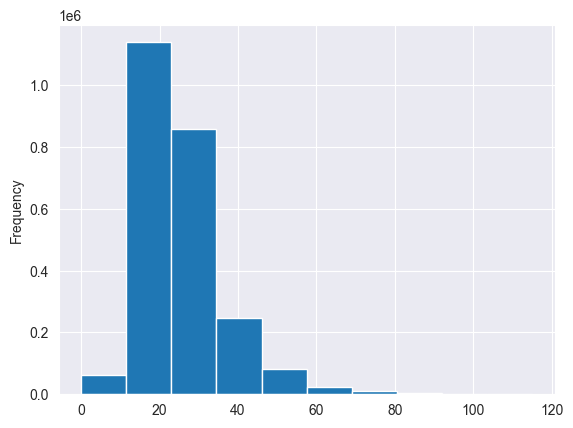

In [27]:
affiliations["levehnstein"].plot(kind="hist")

<Axes: ylabel='Frequency'>

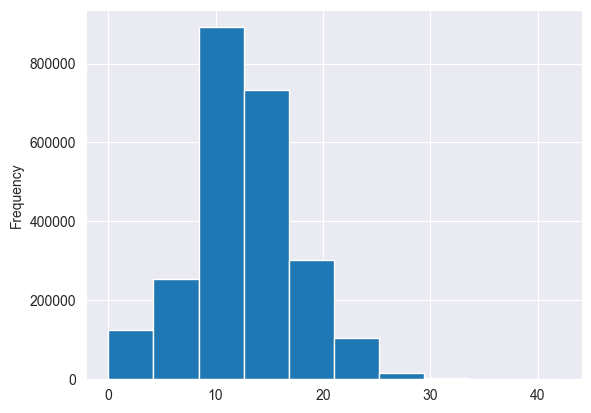

In [74]:
affiliations["token_overlap"].plot(kind="hist")

In [29]:
affiliations[affiliations["Affiliations"].str.contains("A*STAR",regex=False)]

UT (Unique WOS ID)   
136998   WOS:000321029900001  \
136999   WOS:000321029900001   
137000   WOS:000321029900001   
137001   WOS:000321029900001   
137002   WOS:000321029900001   
...                      ...   
2426115  WOS:000934156000001   
2426116  WOS:000934156000001   
2426117  WOS:000934156000001   
2426118  WOS:000934156000001   
2426119  WOS:000934156000001   

                                              Affiliations   
136998   AGENCY FOR SCIENCE TECHNOLOGY & RESEARCH (A*STAR)  \
136999   AGENCY FOR SCIENCE TECHNOLOGY & RESEARCH (A*STAR)   
137000   AGENCY FOR SCIENCE TECHNOLOGY & RESEARCH (A*STAR)   
137001   AGENCY FOR SCIENCE TECHNOLOGY & RESEARCH (A*STAR)   
137002             A*STAR - BIOINFORMATICS INSTITUTE (BII)   
...                                                    ...   
2426115  A*STAR - INSTITUTE OF HIGH PERFORMANCE COMPUTI...   
2426116  A*STAR - INSTITUTE OF HIGH PERFORMANCE COMPUTI...   
2426117  A*STAR - INSTITUTE OF HIGH PERFORMANCE COMPUTI...   
2426118  A*STAR - INSTITUTE OF HIGH PERFORMANCE COMPUTI...   
2426119  A*STAR - INSTITUTE OF HIGH PERFORMANCE COMPUTI...   

                                       Affiliations_merged   
136998     AGENCY FOR SCIENCE TECHNOLOGY & RESEARCH A*STAR  \
136999     AGENCY FOR SCIENCE TECHNOLOGY & RESEARCH A*STAR   
137000     AGENCY FOR SCIENCE TECHNOLOGY & RESEARCH A*STAR   
137001     AGENCY FOR SCIENCE TECHNOLOGY & RESEARCH A*STAR   
137002               A*STAR - BIOINFORMATICS INSTITUTE BII   
...                                                    ...   
2426115  A*STAR - INSTITUTE OF HIGH PERFORMANCE COMPUTI...   
2426116  A*STAR - INSTITUTE OF HIGH PERFORMANCE COMPUTI...   
2426117  A*STAR - INSTITUTE OF HIGH PERFORMANCE COMPUTI...   
2426118  A*STAR - INSTITUTE OF HIGH PERFORMANCE COMPUTI...   
2426119  A*STAR - INSTITUTE OF HIGH PERFORMANCE COMPUTI...   

                                                   Address         Country   
136998    Univ Oulu, Ctr Machine Vis Res, SF-90100 Oulu...         Finland  \
136999    Univ Calif Santa Barbara, Dept Comp Sci, Sant...   United States   
137000    Chinese Acad Sci, NLPR, Inst Automat, Beijing...           China   
137001    Natl Univ Singapore, Bioinformat Inst, A STAR...       Singapore   
137002    Univ Oulu, Ctr Machine Vis Res, SF-90100 Oulu...         Finland   
...                                                    ...             ...   
2426115   Chinese Acad Sci, Ningbo Inst Mat Technol & E...           China   
2426116   Univ N Carolina, Dept Radiol, Chapel Hill, NC...   United States   
2426117   Univ Cambridge, DAMTP, Cambridge CB2 1TN, Eng...  United Kingdom   
2426118   Univ Leeds, Computat Med & Royal Acad, Leeds ...  United Kingdom   
2426119     Katholieke Univ Leuven, B-3000 Leuven, Belgium         Belgium   

                  City Country_Type               Institution  levehnstein  
136998            Oulu           EU                 UNIV OULU           45  
136999   Santa Barbara        Other  UNIV CALIF SANTA BARBARA           37  
137000         Beijing        China          CHINESE ACAD SCI           40  
137001       Singapore        Other       NATL UNIV SINGAPORE           41  
137002            Oulu           EU                 UNIV OULU           35  
...                ...          ...                       ...          ...  
2426115        Beijing        China          CHINESE ACAD SCI           47  
2426116       Carolina        Other           UNIV N CAROLINA           47  
2426117      Cambridge        Other            UNIV CAMBRIDGE           48  
2426118          Leeds        Other                UNIV LEEDS           50  
2426119         Leuven           EU    KATHOLIEKE UNIV LEUVEN           45  

[711 rows x 9 columns]

In [133]:
affiliations = affiliations.sort_values(by=[record_col,"Affiliations","levehnstein"], ascending=[False,False,True])
affiliations_merge = affiliations.drop_duplicates(subset=[record_col,"Affiliations"])
affiliations_merge.head(10)

UT (Unique WOS ID)                               Affiliations   
2430154  WOS:000947693400001        UNIVERSITAT POLITECNICA DE VALENCIA  \
2430132  WOS:000947693400001                    SHANGHAITECH UNIVERSITY   
2430139  WOS:000947693400001                  SHANGHAI OCEAN UNIVERSITY   
2430146  WOS:000947693400001              SHANGHAI JIAO TONG UNIVERSITY   
2430125  WOS:000947693400001                          HUZHOU UNIVERSITY   
2430113  WOS:000946746700001  SUZHOU UNIVERSITY OF SCIENCE & TECHNOLOGY   
2430118  WOS:000946746700001            POLYTECHNIC UNIVERSITY OF MILAN   
2430123  WOS:000946746700001           HONG KONG POLYTECHNIC UNIVERSITY   
2430111  WOS:000945297300001                     UNIVERSITY OF PANNONIA   
2430107  WOS:000945297300001          SHENYANG UNIVERSITY OF TECHNOLOGY   

                               Affiliations_merged   
2430154        UNIVERSITAT POLITECNICA DE VALENCIA  \
2430132                    SHANGHAITECH UNIVERSITY   
2430139                        SHANGHAI UNIVERSITY   
2430146                        SHANGHAI UNIVERSITY   
2430125                          HUZHOU UNIVERSITY   
2430113  SUZHOU UNIVERSITY OF SCIENCE & TECHNOLOGY   
2430118                        UNIVERSITY OF MILAN   
2430123           HONG KONG POLYTECHNIC UNIVERSITY   
2430111                     UNIVERSITY OF PANNONIA   
2430107                        SHENYANG UNIVERSITY   

                                                   Address  Country   
2430154   Univ Politecn Valencia, European Inst Innovat...    Spain  \
2430132   ShanghaiTech Univ, Shanghai Inst Adv Immunoch...    China   
2430139   Shanghai Ocean Univ, Coll Fisheries & Life Sc...    China   
2430146   Shanghai Jiao Tong Univ, Ruijin Hosp, Sch Med...    China   
2430125   Huzhou Univ, Sch Informat Engn, Huzhou 313000...    China   
2430113   Suzhou Univ Sci & Technol, Sch Elect & Inform...    China   
2430118     Politecn Milan, Dept Mech Engn, Milan, Italy;     Italy   
2430123   Hong Kong Polytech Univ, Dept Comp, Hong Kong...    China   
2430111   Univ Pannonia, Dept Elect Engn & Informat Sys...  Hungary   
2430107   Shenyang Univ Technol, Sch Elect Engn, Dept B...    China   

              City Country_Type                Institution  levehnstein  
2430154   Valencia           EU     UNIV POLITECN VALENCIA           13  
2430132   Shanghai        China          SHANGHAITECH UNIV            6  
2430139   Shanghai        China        SHANGHAI OCEAN UNIV            6  
2430146       Meda        China    SHANGHAI JIAO TONG UNIV            6  
2430125     Huzhou        China                HUZHOU UNIV            6  
2430113     Suzhou        China  SUZHOU UNIV SCI & TECHNOL           16  
2430118     Milano           EU             POLITECN MILAN           18  
2430123  Hong Kong        China    HONG KONG POLYTECH UNIV            9  
2430111   Veszprém           EU              UNIV PANNONIA            9  
2430107   Shenyang        China      SHENYANG UNIV TECHNOL           12

In [91]:
wos_cat = wos.groupby(record_col)["WoS Categories"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_1")
wos_cat["WoS Categories"].value_counts()

WoS Categories
 Engineering, Electrical & Electronic         1703
Computer Science, Artificial Intelligence     1366
Computer Science, Information Systems          973
 Telecommunications                            834
 Imaging Science & Photographic Technology     762
                                              ... 
 Crystallography                                 1
Mining & Mineral Processing                      1
 Art                                             1
Archaeology                                      1
Physics, Mathematical                            1
Name: count, Length: 379, dtype: int64

In [92]:
wos_areas = wos.groupby(record_col)["Research Areas"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_1")
wos_areas["Research Areas"] = wos_areas["Research Areas"].str.strip()
wos_areas["Research Areas"].value_counts()

Research Areas
Engineering                                  3740
Computer Science                             3466
Telecommunications                            888
Imaging Science & Photographic Technology     779
Remote Sensing                                716
                                             ... 
Otorhinolaryngology                             1
Medical Ethics                                  1
Anesthesiology                                  1
Biomedical Social Sciences                      1
History & Philosophy of Science                 1
Name: count, Length: 141, dtype: int64

In [93]:
wos_areas["Research Areas"].value_counts()

Research Areas
Engineering                                  3740
Computer Science                             3466
Telecommunications                            888
Imaging Science & Photographic Technology     779
Remote Sensing                                716
                                             ... 
Otorhinolaryngology                             1
Medical Ethics                                  1
Anesthesiology                                  1
Biomedical Social Sciences                      1
History & Philosophy of Science                 1
Name: count, Length: 141, dtype: int64

In [94]:
[c for c in wos.columns if "_English" in c]

['Domain_English', 'Field_English', 'SubField_English']

In [95]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import math

In [96]:
wos = wos[((wos["Publication Year"]<2023) & (~wos['Domain_English'].isna()))]

metrix_levels = [c for c in wos.columns if "_English" in c]
for m in metrix_levels:
    wos[m] = wos[m].replace({"article-level classification":"Miscellaneous"})


In [97]:
wos

Publication Type                                            Authors   
0                    J           Salucci, M; Arrebola, M; Shan, T; Li, MK  \
9714                 J                     Huang, Y; Fu, ZT; Franzke, CLE   
9697                 J  Feng, DC; Cetiner, B; Kakavand, MRA; Taciroglu, E   
9699                 J           Zhao, YL; Dong, S; Jiang, FY; Soares, CG   
9701                 J  Li, XH; Yang, DK; Yang, JS; Zheng, G; Han, GQ;...   
...                ...                                                ...   
3066                 J  He, Q; Zha, C; Song, W; Hao, ZZ; Du, YL; Liott...   
5097                 J                        Hasan, MM; Popp, J; Olah, J   
11369                J                 Li, Y; Cheng, G; Pang, YS; Kuai, M   
11368                J  Zeng, R; Rossiter, DG; Zhang, JP; Cai, K; Gao,...   
11362                J  Jia, Y; Jin, SG; Savi, P; Gao, Y; Tang, J; Che...   

      Book Authors Book Editors Book Group Authors   
0              NaN          NaN                NaN  \
9714           NaN          NaN                NaN   
9697           NaN          NaN                NaN   
9699           NaN          NaN                NaN   
9701           NaN          NaN                NaN   
...            ...          ...                ...   
3066           NaN          NaN                NaN   
5097           NaN          NaN                NaN   
11369          NaN          NaN                NaN   
11368          NaN          NaN                NaN   
11362          NaN          NaN                NaN   

                                       Author Full Names   
0      Salucci, Marco; Arrebola, Manuel; Shan, Tao; L...  \
9714     Huang, Yu; Fu, Zuntao; Franzke, Christian L. E.   
9697   Feng, De-Cheng; Cetiner, Barbaros; Kakavand, M...   
9699   Zhao, Yuliang; Dong, Sheng; Jiang, Fengyuan; G...   
9701   Li, Xiaohui; Yang, Dongkai; Yang, Jingsong; Zh...   
...                                                  ...   
3066   He, Qi; Zha, Cheng; Song, Wei; Hao, Zengzhou; ...   
5097      Hasan, Md Morshadul; Popp, Jozsef; Olah, Judit   
11369  Li, Yong; Cheng, Gang; Pang, Yusong; Kuai, Moshen   
11368  Zeng, Rong; Rossiter, David G.; Zhang, Jiapeng...   
11362  Jia, Yan; Jin, Shuanggen; Savi, Patrizia; Gao,...   

      Book Author Full Names Group Authors   
0                        NaN           NaN  \
9714                     NaN           NaN   
9697                     NaN           NaN   
9699                     NaN           NaN   
9701                     NaN           NaN   
...                      ...           ...   
3066                     NaN           NaN   
5097                     NaN           NaN   
11369                    NaN           NaN   
11368                    NaN           NaN   
11362                    NaN           NaN   

                                           Article Title   
0      Artificial Intelligence: New Frontiers in Real...  \
9714   Detecting causality from time series in a mach...   
9697   Data-Driven Approach to Predict the Plastic Hi...   
9699   System Reliability Analysis of an Offshore Jac...   
9701   Analysis of coastal wind speed retrieval from ...   
...                                                  ...   
3066   Improved Particle Swarm Optimization for Sea S...   
5097   Current landscape and influence of big data on...   
11369  Planetary Gear Fault Diagnosis via Feature Ima...   
11368  How Well Can Reflectance Spectroscopy Allocate...   
11362  GNSS-R Soil Moisture Retrieval Based on a XGbo...   

                                        Source Title  ...   
0      IEEE TRANSACTIONS ON ANTENNAS AND PROPAGATION  ...  \
9714                                           CHAOS  ...   
9697               JOURNAL OF STRUCTURAL ENGINEERING  ...   
9699            JOURNAL OF OCEAN UNIVERSITY OF CHINA  ...   
9701                   REMOTE SENSING OF ENVIRONMENT  ...   
...                                              ...  ...   
3066      

In [98]:
metrix_levels

['Domain_English', 'Field_English', 'SubField_English']

In [101]:
outdir="wos_processed_data"

In [134]:
os.makedirs(outdir, exist_ok=True)

wos.to_excel(f"{outdir}/wos_processed.xlsx", index=False)

locations.drop(columns="Addresses").to_excel(f"{outdir}/wos_addresses.xlsx", index=False)

affiliations_merge.to_excel(f"{outdir}/wos_affiliations.xlsx", index=False)

author_locations.to_excel(f"{outdir}/wos_author_locations.xlsx", index=False)

univ_locations.to_excel(f"{outdir}/wos_univ_locations.xlsx", index=False)
mode_final.to_excel(f"{outdir}/wos_univ_locations_v2.xlsx", index=False)

# Domain

In [31]:
group = 'Domain_English'
data = wos.groupby(group, as_index=False)[record_col].nunique().sort_values(ascending=False, by=record_col)
data

Domain_English  UT (Unique WOS ID)
0            Applied Sciences                5379
5            Natural Sciences                1649
3             Health Sciences                1106
2  Economic & Social Sciences                 289
4               Miscellaneous                 156
1           Arts & Humanities                  13

<Axes: xlabel='UT (Unique WOS ID)', ylabel='Domain_English'>

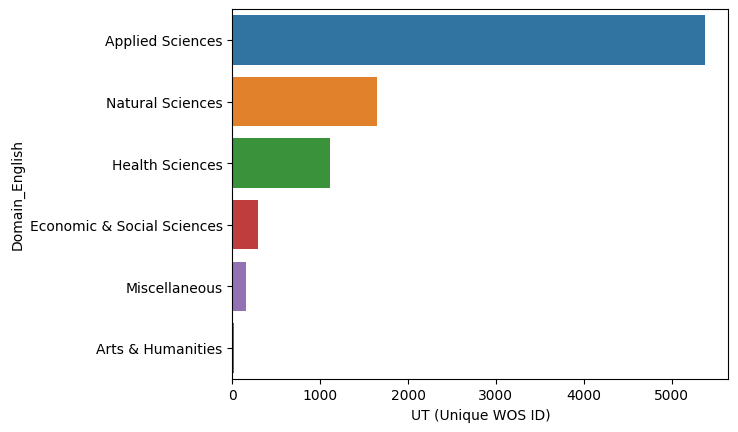

In [32]:
sns.barplot(data, x=record_col, y=group)

In [33]:
# group = ['Publication Year','Domain_English']
# data = wos.groupby(group, as_index=False)[record_col].nunique().sort_values(ascending=False, by=group+[record_col])
# data

In [34]:
group = ['Publication Year','Domain_English']
data = wos.groupby(group)[record_col].nunique().unstack(fill_value=0).stack().reset_index().rename(columns={0:record_col}).sort_values(ascending=False, by=group+[record_col])
data

Publication Year              Domain_English  UT (Unique WOS ID)
65            2022.0            Natural Sciences                 524
64            2022.0               Miscellaneous                  41
63            2022.0             Health Sciences                 368
62            2022.0  Economic & Social Sciences                 106
61            2022.0           Arts & Humanities                   4
..               ...                         ...                 ...
4             2012.0               Miscellaneous                   3
3             2012.0             Health Sciences                   2
2             2012.0  Economic & Social Sciences                   0
1             2012.0           Arts & Humanities                   0
0             2012.0            Applied Sciences                  21

[66 rows x 3 columns]

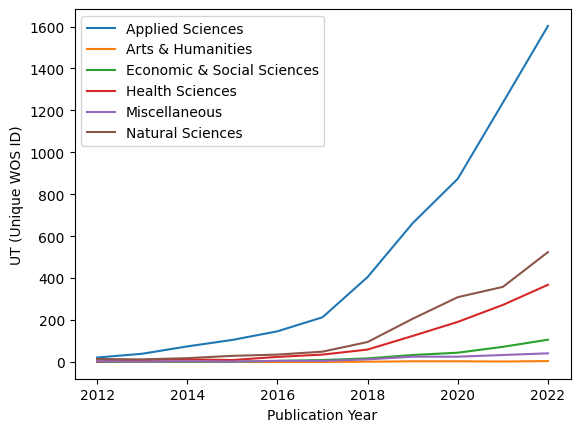

In [35]:
g=sns.lineplot(data.sort_values(ascending=True, by=group[-1]),y=record_col,x=group[0], hue=group[-1])
g.set(xticks=list(range(2012,2022+1,2)))
g.legend(title=None)

# Field

In [65]:
group = ['Publication Year',"Domain_English",'Field_English']
data = wos.groupby(group, as_index=False)[record_col].nunique().sort_values(ascending=False, by=group+[record_col])
data

Publication Year    Domain_English   
176            2022.0  Natural Sciences  \
175            2022.0  Natural Sciences   
174            2022.0  Natural Sciences   
173            2022.0  Natural Sciences   
172            2022.0  Natural Sciences   
..                ...               ...   
4              2012.0     Miscellaneous   
3              2012.0   Health Sciences   
2              2012.0  Applied Sciences   
1              2012.0  Applied Sciences   
0              2012.0  Applied Sciences   

                                Field_English  UT (Unique WOS ID)  
176                       Physics & Astronomy                 205  
175                  Mathematics & Statistics                  61  
174            Earth & Environmental Sciences                 134  
173                                 Chemistry                  81  
172                                   Biology                  43  
..                                        ...                 ...  
4                               Miscellaneous                   3  
3                           Clinical Medicine                   2  
2    Information & Communication Technologies                  14  
1                                 Engineering                   5  
0           Agriculture, Fisheries & Forestry                   2  

[177 rows x 4 columns]

In [37]:
# g = sns.FacetGrid(data, col="Domain_English", col_wrap=3, height=5)
# g.map_dataframe(sns.lineplot,x=group[0],y=record_col,hue=group[-1])
# g.set_titles(col_template="{col_name}")
# g.set(xticks=list(range(2012,2022+1,2)))
# # g.add_legend()

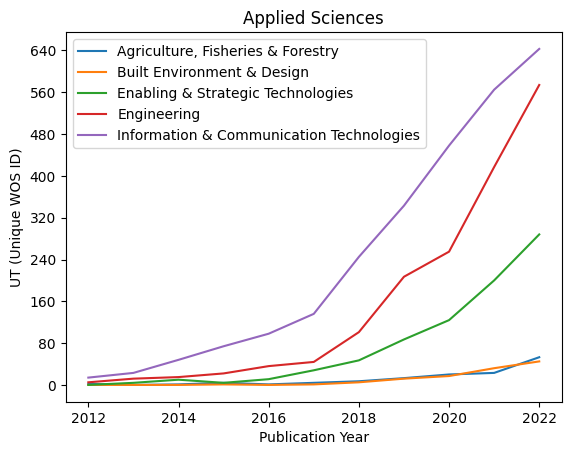

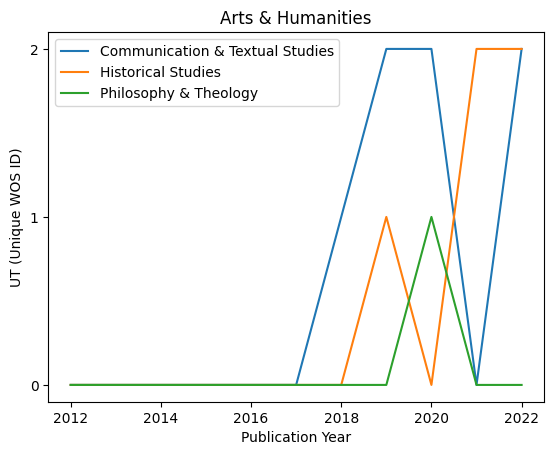

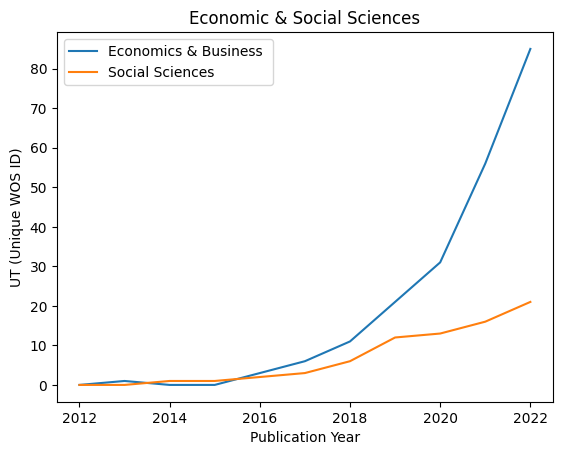

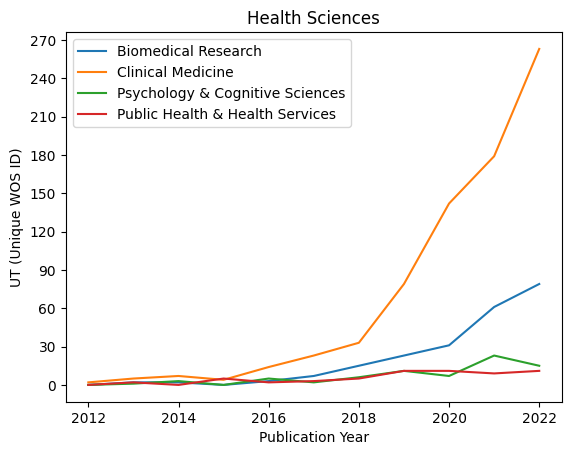

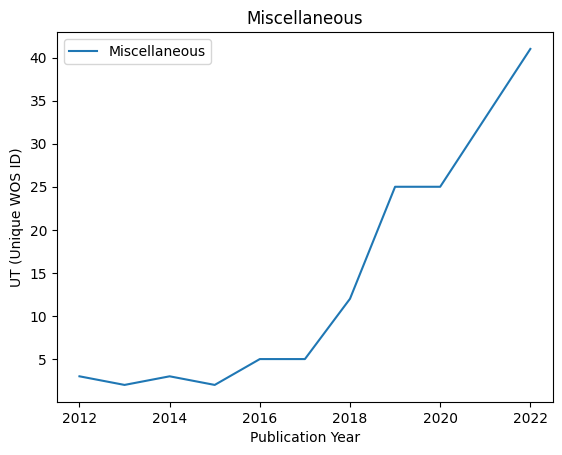

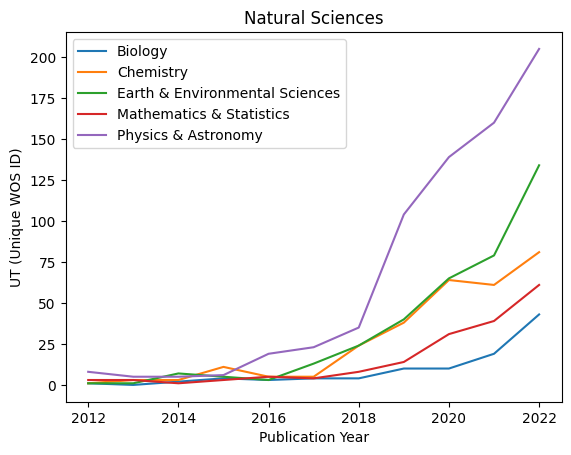

In [66]:
import matplotlib.pyplot as plt
for cat in sorted(data[group[-2]].unique()):
    sub_data = data[data[group[-2]]==cat]
    sub_data = sub_data.complete({group[0]:range(int(data[group[0]].min()), int(data[group[0]].max()) + 1)}
                                 ,group[-1],fill_value=0)
    g=sns.lineplot(sub_data.sort_values(ascending=True, by=group[-1]),y=record_col,x=group[0], hue=group[-1])
    g.set(xticks=list(range(2012,2022+1,2)))
    g.legend(title=None)
    g.set_title(cat)
    g.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

# SubField

In [68]:
group = ['Publication Year',"Domain_English",'Field_English',"SubField_English"]
data = wos.groupby(group, as_index=False)[record_col].nunique().sort_values(ascending=False, by=group+[record_col])
data

Publication Year    Domain_English   
774            2022.0  Natural Sciences  \
773            2022.0  Natural Sciences   
772            2022.0  Natural Sciences   
771            2022.0  Natural Sciences   
770            2022.0  Natural Sciences   
..                ...               ...   
4              2012.0  Applied Sciences   
3              2012.0  Applied Sciences   
2              2012.0  Applied Sciences   
1              2012.0  Applied Sciences   
0              2012.0  Applied Sciences   

                                Field_English   
774                       Physics & Astronomy  \
773                       Physics & Astronomy   
772                       Physics & Astronomy   
771                       Physics & Astronomy   
770                       Physics & Astronomy   
..                                        ...   
4    Information & Communication Technologies   
3                                 Engineering   
2                                 Engineering   
1                                 Engineering   
0           Agriculture, Fisheries & Forestry   

                               SubField_English  UT (Unique WOS ID)  
774                                      Optics                  56  
773                  Nuclear & Particle Physics                  28  
772                        Mathematical Physics                   2  
771                             General Physics                  14  
770                            Fluids & Plasmas                  21  
..                                          ...                 ...  
4    Artificial Intelligence & Image Processing                  10  
3           Mechanical Engineering & Transports                   1  
2           Industrial Engineering & Automation                   3  
1            Geological & Geomatics Engineering                   1  
0                                  Food Science                   2  

[775 rows x 5 columns]

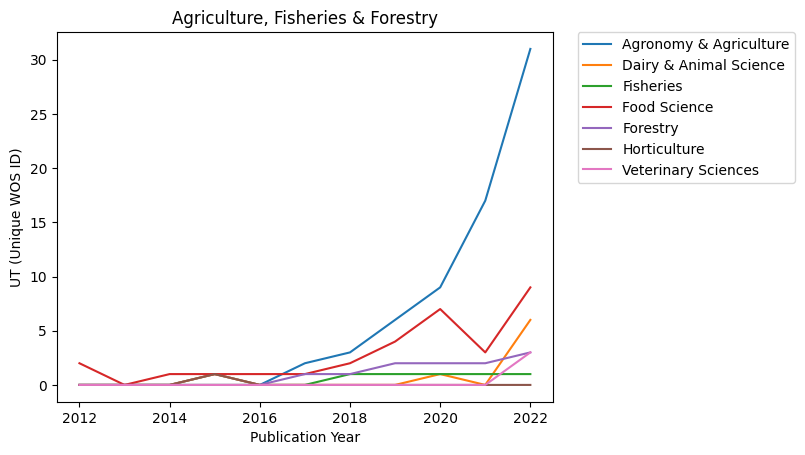

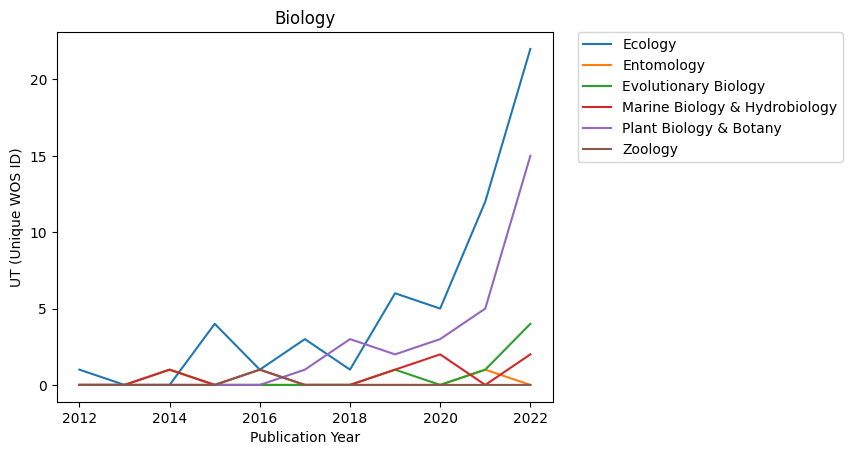

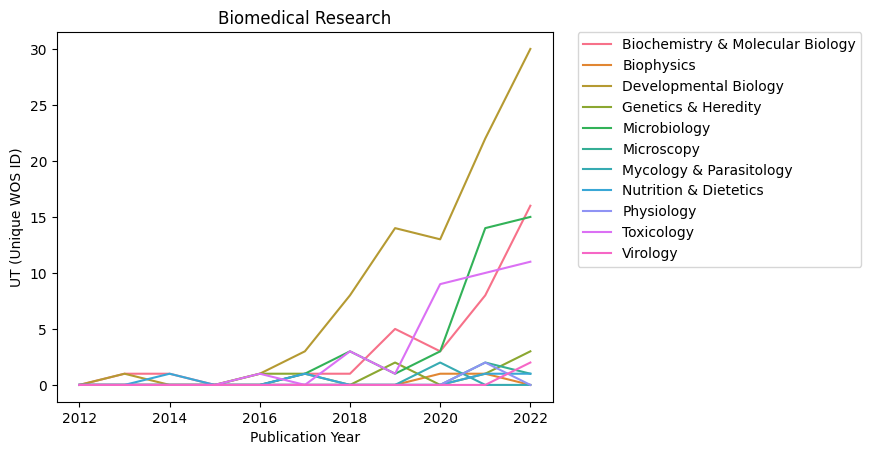

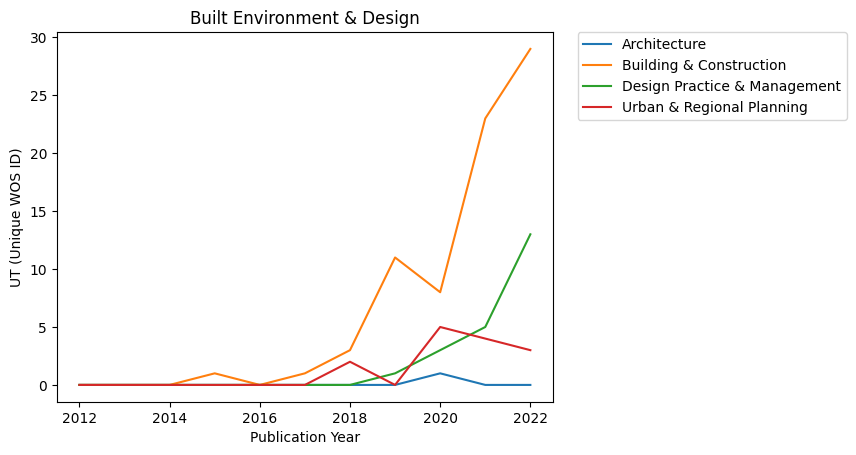

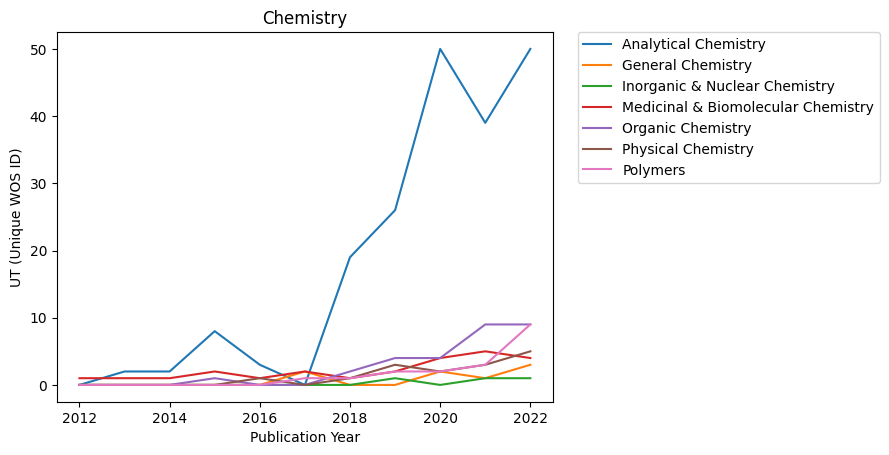

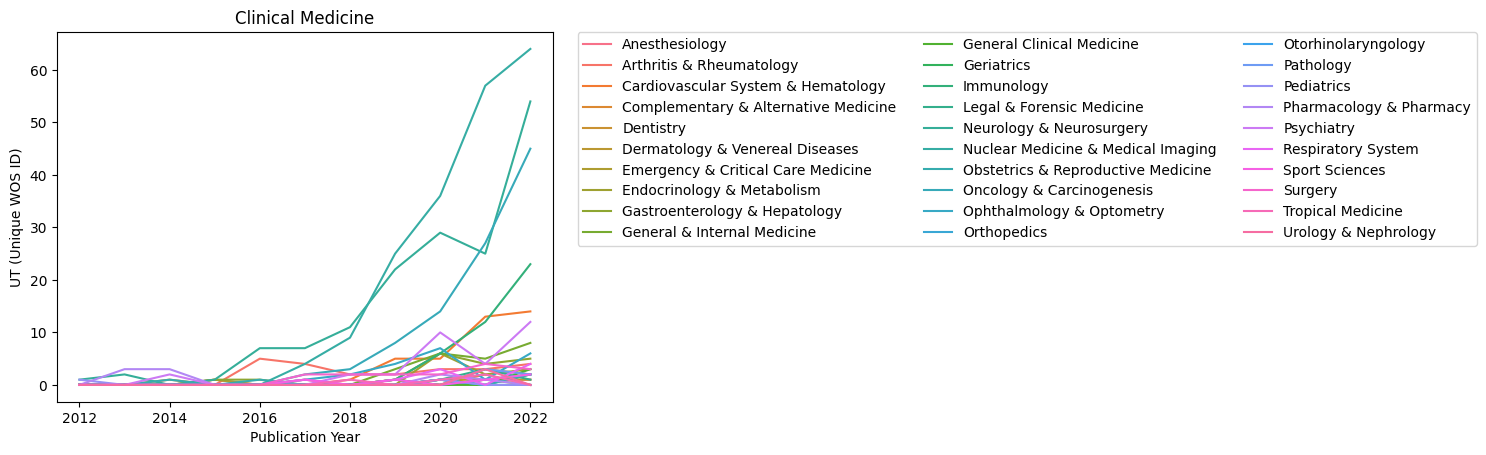

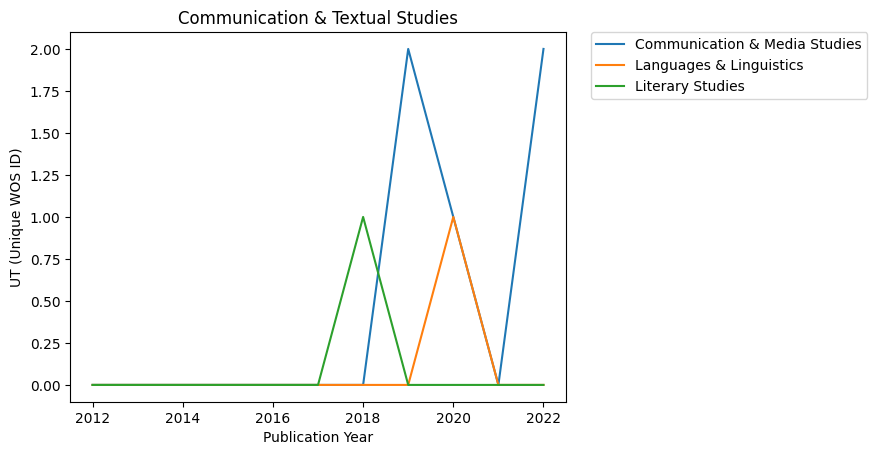

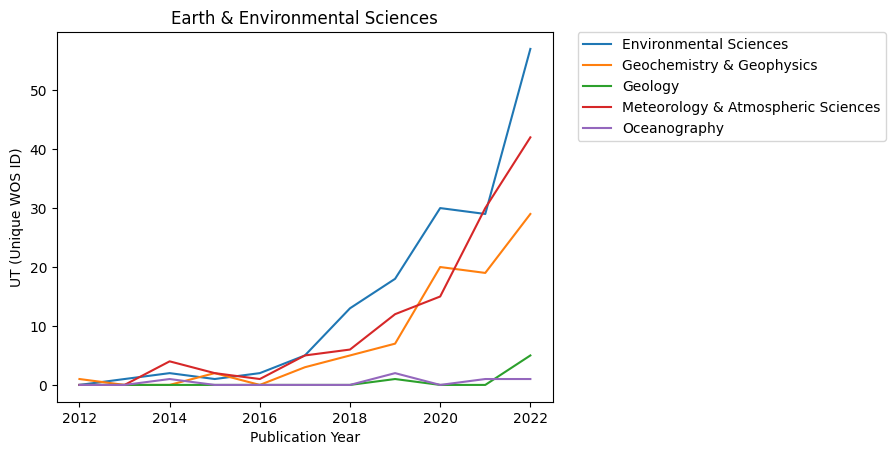

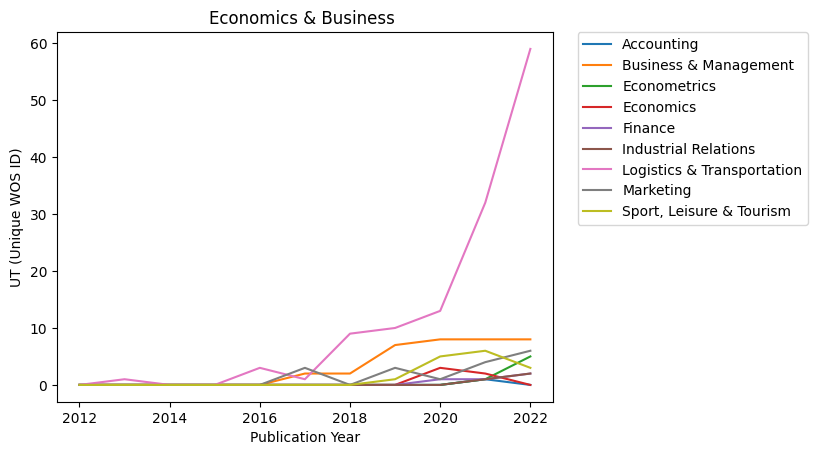

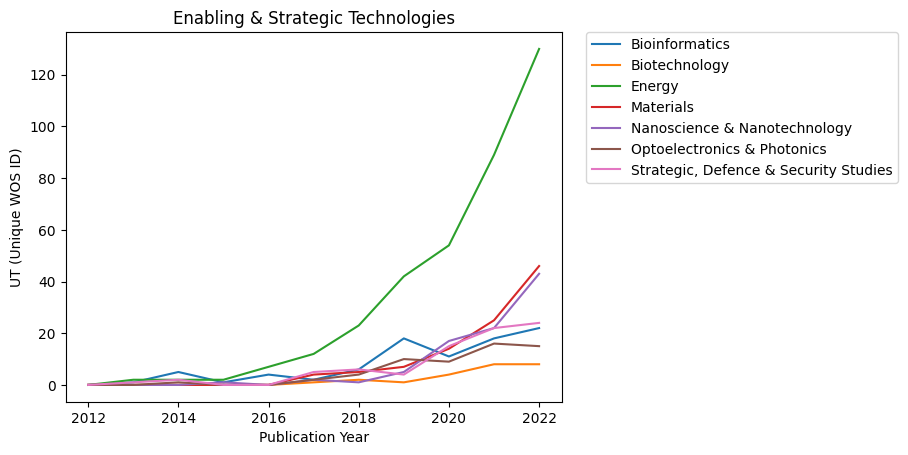

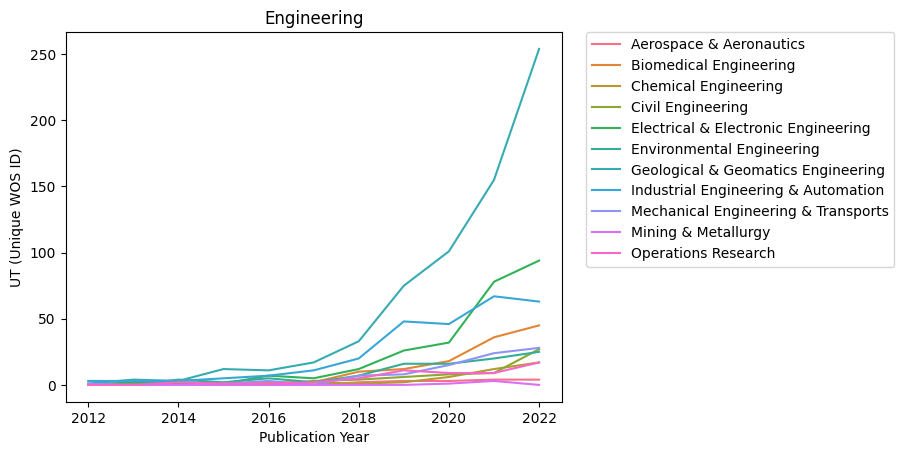

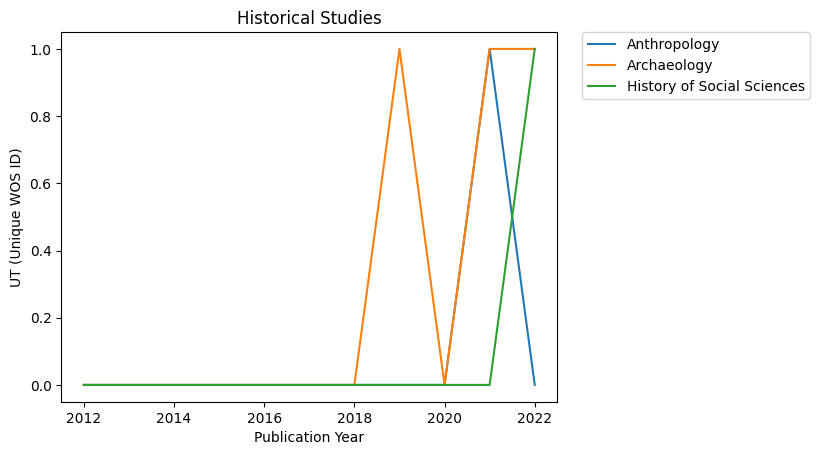

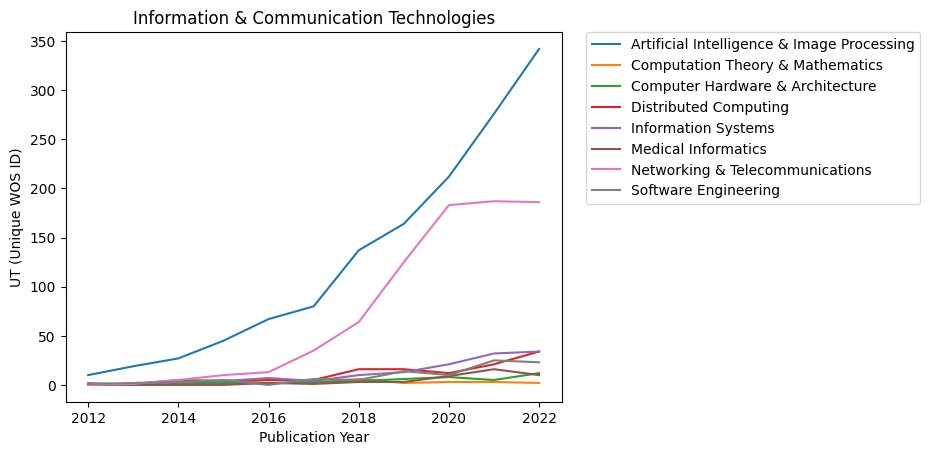

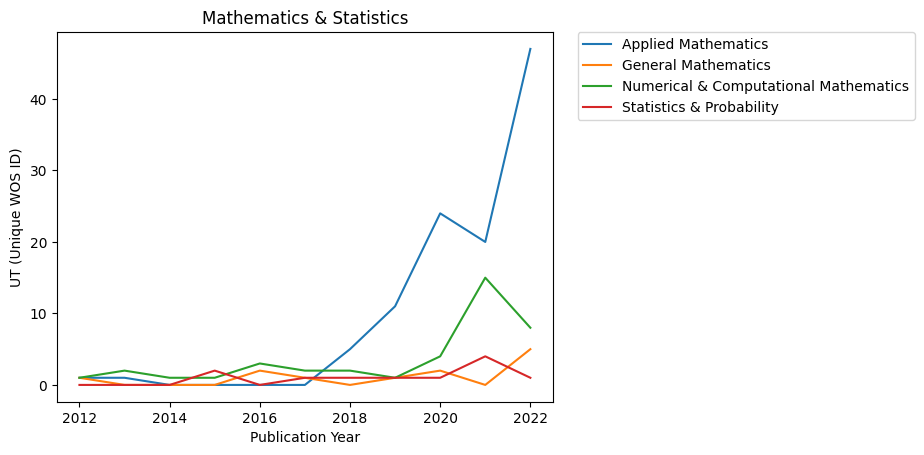

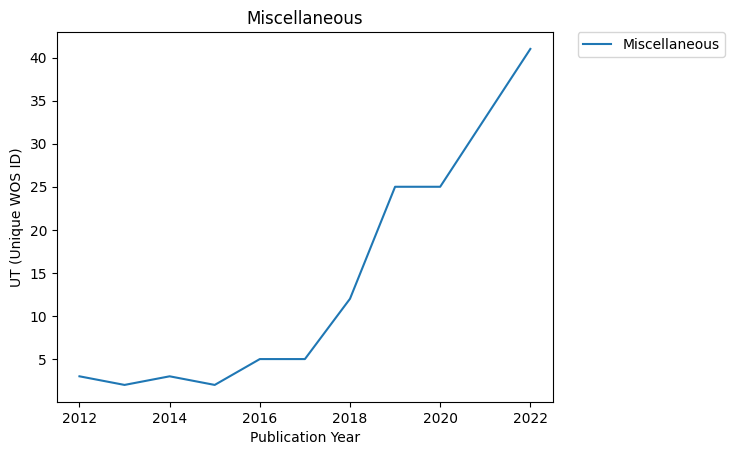

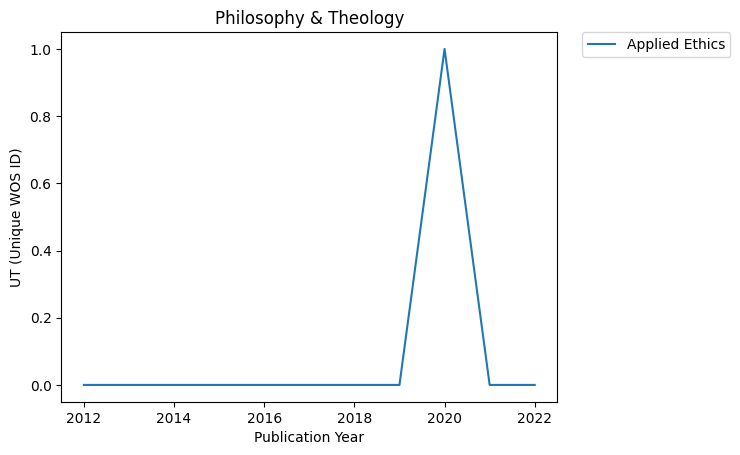

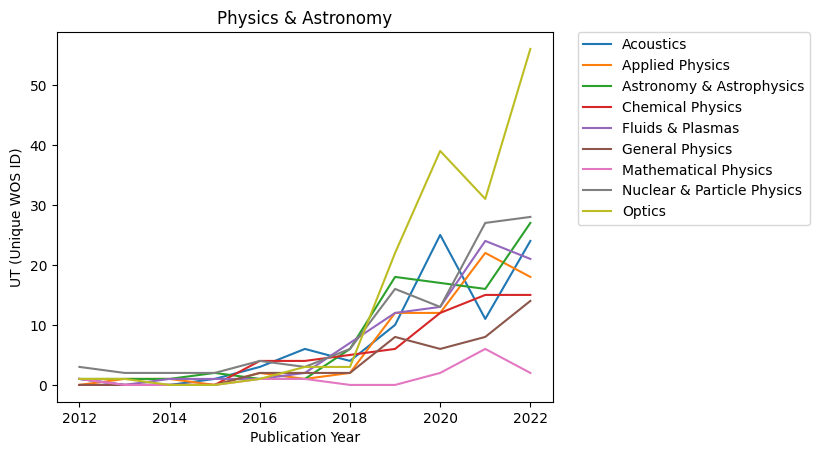

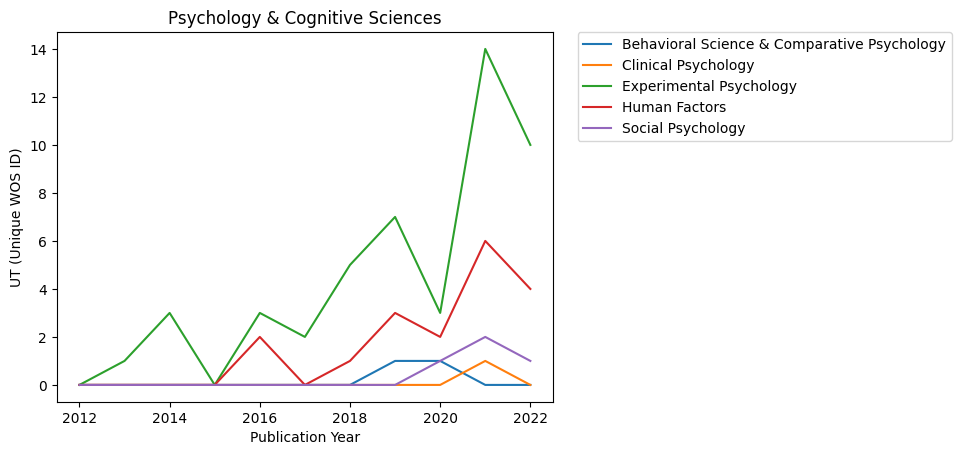

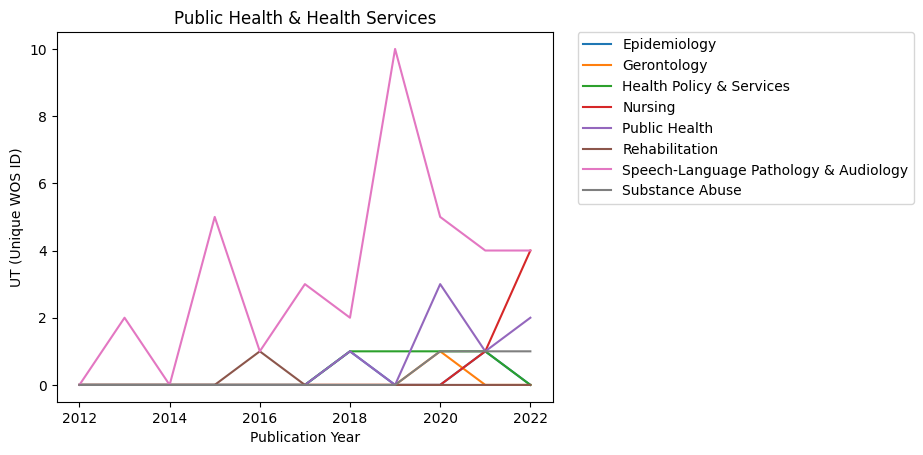

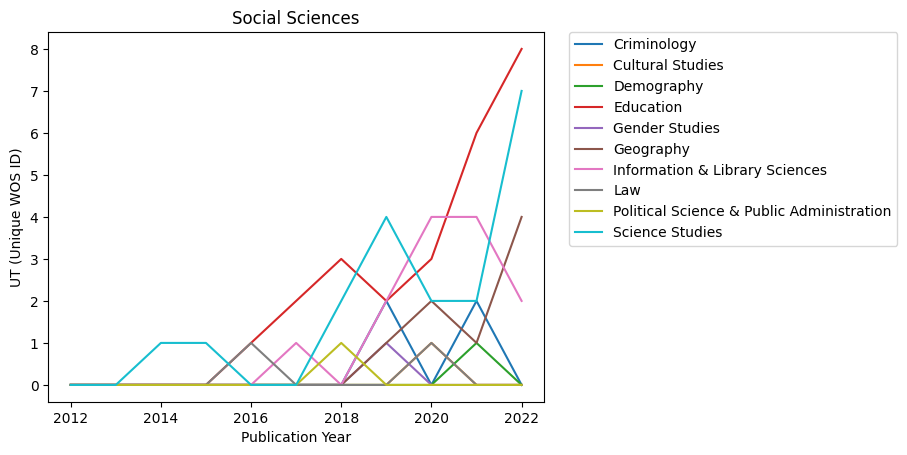

In [69]:
import matplotlib.pyplot as plt
for cat in sorted(data[group[-2]].unique()):
    sub_data = data[data[group[-2]]==cat]
    sub_data = sub_data.complete({group[0]:range(int(data[group[0]].min()), int(data[group[0]].max()) + 1)}
                                 ,group[-1],fill_value=0)
    g=sns.lineplot(sub_data.sort_values(ascending=True, by=group[-1]),y=record_col,x=group[0], hue=group[-1])
    g.set(xticks=list(range(2012,2022+1,2)))
    g.legend(title=None,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncols=math.ceil(len(g.legend_.texts)/12))
    g.set_title(cat)
    plt.show()